In [ ]:
!pip install ultralytics==8.3.20  # or latest if you want

import torch, os
print("CUDA Available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 50.8 MB/s eta 0:00:00
CUDA Available: True
✅ Device: cuda


In [ ]:
import os
import shutil
import random
import yaml

# ============================
# 🚀 EDIT THESE PATHS:
# ============================
SOURCE_DATASET = "/content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset"
OUTPUT_DATASET = "/content/drive/MyDrive/YOLO_Fish_Disease_Dataset"
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
# ============================

# Create output directories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DATASET, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DATASET, split, "labels"), exist_ok=True)

# Detect class folders
classes = [d for d in os.listdir(SOURCE_DATASET) if os.path.isdir(os.path.join(SOURCE_DATASET, d))]
print("Detected Classes =", classes)

# Process each class
for class_id, class_name in enumerate(classes):
    print(f"\n🔄 Processing class: {class_name} (ID: {class_id})")

    img_dir = os.path.join(SOURCE_DATASET, class_name, "images")
    label_dir = os.path.join(SOURCE_DATASET, class_name, "labels")

    images = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    # COPY FUNCTION
    def copy_files(files, split):
        for img_file in files:
            img_src = os.path.join(img_dir, img_file)
            label_file = img_file.rsplit(".", 1)[0] + ".txt"
            label_src = os.path.join(label_dir, label_file)

            img_dst = os.path.join(OUTPUT_DATASET, split, "images", img_file)
            label_dst = os.path.join(OUTPUT_DATASET, split, "labels", label_file)

            shutil.copy(img_src, img_dst)
            if os.path.exists(label_src):
                shutil.copy(label_src, label_dst)

    copy_files(train_imgs, "train")
    copy_files(val_imgs, "val")
    copy_files(test_imgs, "test")

print("\n✅ Dataset SPLITTING DONE!")
print("📁 Output saved to:", OUTPUT_DATASET)

# ============================
# GENERATE dataset.yaml
# ============================

yaml_path = os.path.join(OUTPUT_DATASET, "dataset.yaml")

yaml_dict = {
    "path": OUTPUT_DATASET,
    "train": os.path.join(OUTPUT_DATASET, "train/images"),
    "val": os.path.join(OUTPUT_DATASET, "val/images"),
    "test": os.path.join(OUTPUT_DATASET, "test/images"),
    "names": {i: cls for i, cls in enumerate(classes)}
}

with open(yaml_path, "w") as f:
    yaml.dump(yaml_dict, f, default_flow_style=False)

print("\n📄 YAML File Created Successfully!")
print("🔗 Saved at:", yaml_path)

# Show final class list
print("\n📌 Class Mapping:")
for i, c in enumerate(classes):
    print(f"{i}: {c}")

print("\n🔥 FULL Dataset Ready for YOLOv8/YOLOv11 Training!")


Detected Classes = ['Bacterial red Disease', 'Viral diseases White tail disease', 'Parasitic diseases', 'Bacterial gill Disease', 'Fungal Disease', 'Bacterial diseases', 'Healthy fish', 'YOLO_Dataset']

🔄 Processing class: Bacterial red Disease (ID: 0)

🔄 Processing class: Viral diseases White tail disease (ID: 1)

🔄 Processing class: Parasitic diseases (ID: 2)

🔄 Processing class: Bacterial gill Disease (ID: 3)

🔄 Processing class: Fungal Disease (ID: 4)

🔄 Processing class: Bacterial diseases (ID: 5)

🔄 Processing class: Healthy fish (ID: 6)

🔄 Processing class: YOLO_Dataset (ID: 7)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/YOLO_Dataset/images'

In [ ]:
# ============================
# GENERATE dataset.yaml
# ============================

yaml_path = os.path.join(OUTPUT_DATASET, "dataset.yaml")

yaml_dict = {
    "path": OUTPUT_DATASET,
    "train": os.path.join(OUTPUT_DATASET, "train/images"),
    "val": os.path.join(OUTPUT_DATASET, "val/images"),
    "test": os.path.join(OUTPUT_DATASET, "test/images"),
    "names": {i: cls for i, cls in enumerate(classes)}
}

with open(yaml_path, "w") as f:
    yaml.dump(yaml_dict, f, default_flow_style=False)

print("\n📄 YAML File Created Successfully!")
print("🔗 Saved at:", yaml_path)

# Show final class list
print("\n📌 Class Mapping:")
for i, c in enumerate(classes):
    print(f"{i}: {c}")

print("\n🔥 FULL Dataset Ready for YOLOv8/YOLOv11 Training!")



📄 YAML File Created Successfully!
🔗 Saved at: /content/drive/MyDrive/YOLO_Fish_Disease_Dataset/dataset.yaml

📌 Class Mapping:
0: Bacterial red Disease
1: Viral diseases White tail disease
2: Parasitic diseases
3: Bacterial gill Disease
4: Fungal Disease
5: Bacterial diseases
6: Healthy fish
7: YOLO_Dataset

🔥 FULL Dataset Ready for YOLOv8/YOLOv11 Training!


In [ ]:
import os
import shutil
import yaml
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm
import torch
import torchvision.ops as ops
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# ================== SECTION 0: USER CONFIG ==================
# Change only these variables as needed

DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"
OUTPUT_ROOT = "/content/drive/MyDrive/Fish_Dataset_Output"   # all outputs saved here

# Model / training defaults
MODEL_NAME = "yolov11s.pt"   # start with s, later try yolov11m.pt / yolov11l.pt
EPOCHS = 50
BATCH = 16
IMGSZ = 640
DEVICE = 0   # GPU id or "cpu"
LR0 = 0.001
PATIENCE = 20

# Inference + analysis
CONF_THRESH = 0.25
IOU_THRESH = 0.5

# Misc
RANDOM_SEED = 42
EXPORT_FORMATS = ["onnx","torchscript"]   # set [] if you don't want exports

# =============================================================
import os, random
random.seed(RANDOM_SEED)
os.makedirs(OUTPUT_ROOT, exist_ok=True)
print("CONFIG loaded. OUTPUT_ROOT:", OUTPUT_ROOT)


CONFIG loaded. OUTPUT_ROOT: /content/drive/MyDrive/Fish_Dataset_Output


In [ ]:
# ========== DOWNLOAD YOLOv11s WEIGHTS TO DRIVE ==========
import os, shutil, sys
from pathlib import Path

# change this if you want another destination
drive_weights_dir = Path("/content/drive/MyDrive/models11")
drive_weights_dir.mkdir(parents=True, exist_ok=True)

# candidate URLs (official/community). If one fails, next will be tried.
urls = [
    # GitHub assets release (works in many cases)
    "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11s.pt",
    # HuggingFace (Ultralytics repo) — raw download link (if available)
    "https://huggingface.co/Ultralytics/YOLO11/resolve/main/yolo11s.pt",
    # fallback: Ultralytics model hub auto-download handled by YOLO(...) if internet works
]

out_path = drive_weights_dir / "yolo11s.pt"

def try_download(url, out_path):
    print("Trying to download from:", url)
    try:
        # use wget (works in Colab)
        cmd = f"wget -c {url} -O {out_path}"
        print("Running:", cmd)
        ret = os.system(cmd)
        return ret == 0
    except Exception as e:
        print("Download error:", e)
        return False

downloaded = False
for u in urls:
    if try_download(u, out_path):
        downloaded = True
        break

# If none of the URLs worked, inform user
if not downloaded:
    print("WARNING: automatic download failed. Possible reasons: URL changed, network blocked, or resource removed.")
    print("Options:\n 1) Upload yolo11s.pt manually to", drive_weights_dir, "\n 2) Provide an alternative download URL")
else:
    # verify file exists and size
    size_mb = out_path.stat().st_size / (1024*1024)
    print(f"Downloaded to {out_path} — size: {size_mb:.2f} MB")


Trying to download from: https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11s.pt
Running: wget -c https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11s.pt -O /content/drive/MyDrive/models11/yolo11s.pt
Downloaded to /content/drive/MyDrive/models11/yolo11s.pt — size: 18.42 MB


In [ ]:
# ===== SECTION 0: CONFIG (No model weights path used) =====

DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"
OUTPUT_ROOT = "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline"

MODEL_NAME = "yolo11s.pt"   # <-- ONLY THIS (fresh auto-download)
EPOCHS = 50
BATCH = 16
IMGSZ = 640
DEVICE = 0
LR0 = 0.01
PATIENCE = 20
CONF_THRESH = 0.25
IOU_THRESH = 0.5

import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("CONFIG loaded. Model:", MODEL_NAME)


CONFIG loaded. Model: yolo11s.pt


In [ ]:
import yaml
from pathlib import Path

yaml_path = "/content/drive/MyDrive/YOLO_Fish_Disease_Dataset/dataset.yaml"  # Corrected path to the YAML file
with open(yaml_path, 'r') as f:
    cfg = yaml.safe_load(f)
print("YAML keys:", list(cfg.keys()))
print(cfg)  # dekhen train/val/test values ki

# If entries are relative, resolve them:
for k in ("train","val","test"):
    if k in cfg:
        p = Path(cfg[k])
        print(k, "->", p, "exists?", p.exists())

YAML keys: ['names', 'path', 'test', 'train', 'val']
{'names': {0: 'Bacterial red Disease', 1: 'Viral diseases White tail disease', 2: 'Parasitic diseases', 3: 'Bacterial gill Disease', 4: 'Fungal Disease', 5: 'Bacterial diseases', 6: 'Healthy fish', 7: 'YOLO_Dataset'}, 'path': '/content/drive/MyDrive/YOLO_Fish_Disease_Dataset', 'test': '/content/drive/MyDrive/YOLO_Fish_Disease_Dataset/test/images', 'train': '/content/drive/MyDrive/YOLO_Fish_Disease_Dataset/train/images', 'val': '/content/drive/MyDrive/YOLO_Fish_Disease_Dataset/val/images'}
train -> /content/drive/MyDrive/YOLO_Fish_Disease_Dataset/train/images exists? True
val -> /content/drive/MyDrive/YOLO_Fish_Disease_Dataset/val/images exists? True
test -> /content/drive/MyDrive/YOLO_Fish_Disease_Dataset/test/images exists? True


In [ ]:
import os
import shutil
import hashlib
import random
from pathlib import Path
from collections import defaultdict
import yaml

# ============================================================
# USER CONFIG
# ============================================================
base_dataset_dir = Path("/content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset")  # <-- আপনার folder
output_dir = Path("/content/drive/MyDrive/split")  # output folder

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
random_seed = 42
copy_files = True
# ============================================================

random.seed(random_seed)

# class list = folders inside "Sign Language"
class_names = sorted([f.name for f in base_dataset_dir.iterdir() if f.is_dir()])
class_to_index = {name: i for i, name in enumerate(class_names)}

print("Found classes:", len(class_names))
print(class_to_index)

# step 1 — collect image+label per class
img_exts = {".jpg", ".jpeg", ".png", ".bmp"}
per_class_files = defaultdict(list)

for class_name in class_names:
    img_dir = base_dataset_dir / class_name / "images"
    lbl_dir = base_dataset_dir / class_name / "labels"
    if not img_dir.exists():
        continue
    for img in img_dir.rglob("*"):
        if img.suffix.lower() not in img_exts:
            continue
        lbl = lbl_dir / (img.stem + ".txt")
        per_class_files[class_name].append((img, lbl))

total_images = sum(len(v) for v in per_class_files.values())
print("Total images found:", total_images)

# step 2 — correct label IDs
print("\nFixing label class-IDs ...")
for class_name, filelist in per_class_files.items():
    global_id = class_to_index[class_name]
    for img, lbl in filelist:
        if lbl.exists():
            lines = lbl.read_text().splitlines()
            new_lines = []
            for ln in lines:
                p = ln.strip().split()
                if len(p) > 0:
                    p[0] = str(global_id)
                new_lines.append(" ".join(p))
            lbl.write_text("\n".join(new_lines))

print("Label fixing done.")

# step 3 — create output folders
for split in ["train", "val", "test"]:
    (output_dir / split / "images").mkdir(parents=True, exist_ok=True)
    (output_dir / split / "labels").mkdir(parents=True, exist_ok=True)

# step 4 — stratified split
print("\nSplitting dataset ...")
for class_name, items in per_class_files.items():
    random.shuffle(items)
    n = len(items)

    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_items = items[:n_train]
    val_items = items[n_train:n_train+n_val]
    test_items = items[n_train+n_val:]

    splits = [("train", train_items), ("val", val_items), ("test", test_items)]

    for split, split_items in splits:
        for img, lbl in split_items:
            dst_img = output_dir / split / "images" / img.name
            dst_lbl = output_dir / split / "labels" / f"{img.stem}.txt"

            if copy_files:
                shutil.copy2(img, dst_img)
            else:
                shutil.move(img, dst_img)

            if lbl.exists():
                if copy_files:
                    shutil.copy2(lbl, dst_lbl)
                else:
                    shutil.move(lbl, dst_lbl)
            else:
                dst_lbl.write_text("")  # empty label if missing

print("Splitting finished.")
print("Output dir:", output_dir)

# step 5 — write YAML for YOLO training
yaml_data = {
    "path": str(output_dir),
    "train": str((output_dir / "train" / "images").resolve()),
    "val": str((output_dir / "val" / "images").resolve()),
    "test": str((output_dir / "test" / "images").resolve()),
    "nc": len(class_names),
    "names": class_names
}

yaml_path = output_dir / "fixed.yaml"
yaml.dump(yaml_data, open(yaml_path, "w"), sort_keys=False)

print("\nGenerated YAML:", yaml_path)


Found classes: 8
{'Bacterial diseases': 0, 'Bacterial gill Disease': 1, 'Bacterial red Disease': 2, 'Fungal Disease': 3, 'Healthy fish': 4, 'Parasitic diseases': 5, 'Viral diseases White tail disease': 6, 'YOLO_Dataset': 7}
Total images found: 7710

Fixing label class-IDs ...
Label fixing done.

Splitting dataset ...
Splitting finished.
Output dir: /content/drive/MyDrive/split

Generated YAML: /content/drive/MyDrive/split/fixed.yaml


In [ ]:
# ===== SECTION 1: TRAIN =====
from ultralytics import YOLO
from ultralytics.utils import SETTINGS
import os

# Disable Weights & Biases to prevent project name validation errors
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"

# Configure Ultralytics to save runs in the specified OUTPUT_ROOT
SETTINGS.update({"runs_dir": OUTPUT_ROOT})

model = YOLO("yolo11s.pt")    # <-- THIS WILL AUTO-DOWNLOAD NEW YOLO11s
print("Model Loaded:", model)

model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    lr0=LR0,
    patience=PATIENCE,
    project="YOLO11_Training_Project", # Use a simple string for the project name
    name="YOLO11_Run1", # Specific run name, will be a subfolder within the project folder
    cache="disk",
    plots=True,
    save=True
)

print("TRAIN DONE.")


Model Loaded: YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True

train: Scanning /content/drive/MyDrive/split/train/labels.cache... 5396 images, 355 backgrounds, 123 corrupt: 100%|██████████| 5396/5396 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0002_jpg.rf.269fa76129eb0155b93290e0a9971eef.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0236]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0023_jpg.rf.75848fc350c1a3b6d1c38f839d1bb80d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.251       1.251]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0056_jpg.rf.c388e33894b413e0137918159093f798.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0191]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0069_jpg.rf.ed61531c8aa8127be2b4cd63bc3736e0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1637      1.1001]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0081_jpg.rf.189eaaa3b3809322558de79f2405aaae.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates 

train: 8.8GB disk space required, with 50% safety margin but only 1.3/15.0GB free, not caching images to disk ⚠️
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/split/val/labels.cache... 1541 images, 99 backgrounds, 40 corrupt: 100%|██████████| 1541/1541 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0046_jpg.rf.a99dd136e6ec8783929ad014db65fbde.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0375      1.1339]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0050_jpg.rf.f1941347487346619937ce13c367cdd6.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1307]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0071_jpg.rf.39015940744b8b0394bb91dfe2a61b92.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0945]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0201_jpg.rf.dbe1530269d10417437d40497a5bffeb.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0097]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0255_jpg.rf.ba14270992bfa6761e11a62f5d0c4ac0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0389]
val: WARNING ⚠️ /c

val: 2.5GB disk space required, with 50% safety margin but only 1.3/15.0GB free, not caching images to disk ⚠️
Plotting labels to YOLO11_Training_Project/YOLO11_Run19/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to YOLO11_Training_Project/YOLO11_Run19
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.86G      1.047      2.734      1.526         22        640: 100%|██████████| 330/330 [01:30<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]

                   all       1501       1629      0.274      0.409      0.276      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.73G      1.155      2.156      1.599         31        640: 100%|██████████| 330/330 [01:28<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]

                   all       1501       1629      0.358      0.332      0.259      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.68G      1.195      2.167      1.633         32        640: 100%|██████████| 330/330 [01:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


                   all       1501       1629      0.403      0.342      0.283      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.69G      1.157      2.103      1.602         28        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]

                   all       1501       1629       0.38      0.467      0.402      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.69G        1.1          2       1.56         35        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]

                   all       1501       1629      0.419      0.478      0.433       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.69G      1.048      1.914      1.518         32        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]

                   all       1501       1629       0.43      0.445      0.426       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.68G      1.005      1.829      1.485         31        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]

                   all       1501       1629        0.5      0.501      0.514      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.69G      1.002       1.79      1.476         33        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]

                   all       1501       1629      0.533      0.494       0.52      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.69G     0.9797      1.733      1.455         26        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.81it/s]

                   all       1501       1629      0.572      0.604      0.596      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       4.7G     0.9522      1.657       1.44         23        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]

                   all       1501       1629      0.558      0.549      0.585      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.68G     0.9319      1.623      1.422         33        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]

                   all       1501       1629      0.614       0.54      0.563      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.69G     0.9213      1.574      1.412         27        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]

                   all       1501       1629      0.624      0.672      0.697      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.69G     0.9203      1.544      1.412         27        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]

                   all       1501       1629      0.641       0.64      0.695      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       4.7G      0.891      1.507      1.388         28        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.81it/s]

                   all       1501       1629      0.655      0.661      0.701      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.68G     0.8829      1.466      1.385         29        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]

                   all       1501       1629       0.75      0.689      0.773      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.69G      0.867      1.403      1.374         29        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]

                   all       1501       1629      0.664      0.685      0.717      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.69G      0.864      1.378      1.367         32        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]

                   all       1501       1629      0.722      0.697      0.764      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       4.7G      0.837      1.339      1.349         31        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]

                   all       1501       1629       0.73      0.747      0.798      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.68G     0.8424      1.318      1.351         27        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]

                   all       1501       1629      0.764      0.782      0.828      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.69G     0.8338      1.316      1.339         25        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]

                   all       1501       1629      0.745      0.771      0.802      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.69G     0.8193      1.273      1.336         24        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]

                   all       1501       1629      0.716      0.765      0.784      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       4.7G     0.8151      1.243      1.329         29        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1501       1629      0.765      0.779      0.836      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.68G      0.803      1.189      1.322         27        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

                   all       1501       1629      0.782      0.805      0.843      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.69G     0.8084      1.214      1.319         17        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]

                   all       1501       1629      0.795      0.824      0.858      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.69G     0.7878      1.164       1.31         26        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

                   all       1501       1629      0.803      0.822      0.865       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.67G     0.7954      1.184      1.317         27        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]

                   all       1501       1629      0.817      0.837      0.883      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.68G     0.7854      1.124      1.299         32        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]

                   all       1501       1629      0.805       0.81      0.857      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.69G     0.7756      1.114      1.298         25        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1501       1629      0.835      0.857      0.893      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.69G     0.7716      1.116      1.298         26        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]

                   all       1501       1629      0.825      0.838      0.884      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       4.7G     0.7607      1.084       1.29         24        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]

                   all       1501       1629      0.834      0.864      0.898      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.68G     0.7327      1.055      1.271         22        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

                   all       1501       1629      0.825      0.856      0.891      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.69G     0.7488      1.038      1.278         34        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]

                   all       1501       1629      0.828      0.882      0.903      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.69G     0.7333      1.013      1.268         29        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]

                   all       1501       1629      0.823      0.849      0.895      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       4.7G     0.7294      1.027       1.26         31        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

                   all       1501       1629      0.825      0.849      0.881      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.68G     0.7185      0.987      1.256         30        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

                   all       1501       1629      0.854       0.87      0.899      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.69G     0.7039     0.9665      1.248         30        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

                   all       1501       1629      0.826      0.888      0.903      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.69G     0.7045     0.9478      1.243         28        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]

                   all       1501       1629      0.841      0.881       0.91      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.67G     0.6974      0.937      1.246         24        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]

                   all       1501       1629      0.866      0.882      0.918      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.68G     0.6926     0.9154       1.24         20        640: 100%|██████████| 330/330 [01:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1501       1629      0.851      0.874      0.909      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.69G     0.6891     0.9114      1.235         20        640: 100%|██████████| 330/330 [01:26<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]

                   all       1501       1629      0.854      0.864       0.91      0.748


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.67G     0.5621     0.6352      1.219          6        640: 100%|██████████| 330/330 [01:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]

                   all       1501       1629      0.856      0.876      0.916       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       4.7G     0.5331     0.5888      1.195         10        640: 100%|██████████| 330/330 [01:25<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]

                   all       1501       1629      0.851       0.88      0.916      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.68G     0.5217     0.5625      1.184          6        640: 100%|██████████| 330/330 [01:25<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]

                   all       1501       1629      0.862      0.884      0.918      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.69G     0.5056     0.5449      1.163         10        640: 100%|██████████| 330/330 [01:25<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1501       1629      0.862      0.888      0.922      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.67G     0.4817     0.5315      1.144          5        640: 100%|██████████| 330/330 [01:25<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1501       1629      0.858      0.893      0.926      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.67G     0.4853     0.5118      1.148          9        640: 100%|██████████| 330/330 [01:25<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1501       1629      0.879      0.881      0.926      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.68G     0.4755     0.5071      1.142          8        640: 100%|██████████| 330/330 [01:25<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]

                   all       1501       1629      0.868      0.905      0.931      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.69G     0.4512     0.4799      1.116          9        640: 100%|██████████| 330/330 [01:25<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1501       1629      0.867      0.888      0.931      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.67G     0.4393      0.471      1.102          8        640: 100%|██████████| 330/330 [01:25<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]

                   all       1501       1629       0.87      0.897      0.931      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.67G     0.4289     0.4469      1.088          5        640: 100%|██████████| 330/330 [01:25<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]

                   all       1501       1629      0.866      0.896      0.927      0.787



50 epochs completed in 1.409 hours.
Optimizer stripped from YOLO11_Training_Project/YOLO11_Run19/weights/last.pt, 19.2MB
Optimizer stripped from YOLO11_Training_Project/YOLO11_Run19/weights/best.pt, 19.2MB

Validating YOLO11_Training_Project/YOLO11_Run19/weights/best.pt...
Ultralytics 8.3.20 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]


                   all       1501       1629      0.867      0.889      0.931      0.788
    Bacterial diseases        200        227      0.848      0.955      0.958      0.849
Bacterial gill Disease        237        245      0.929      0.904      0.965      0.851
 Bacterial red Disease        250        359       0.83      0.792      0.863      0.685
        Fungal Disease        200        227      0.906      0.943      0.975       0.83
          Healthy fish        122        142      0.702      0.761      0.813      0.606
    Parasitic diseases        198        230      0.924      0.894      0.959      0.793
Viral diseases White tail disease        195        199      0.935      0.975      0.981      0.901
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to YOLO11_Training_Project/YOLO11_Run19
TRAIN DONE.


In [ ]:
# ========== SECTION 2: FIND & COPY BEST CHECKPOINT ==========
import glob, shutil, os, pathlib

# Update PROJECT_NAME and RUN_NAME to match the actual training run names
PROJECT_NAME = "YOLO11_Training_Project"
RUN_NAME = "YOLO11_Run19" # Changed RUN_NAME to match the actual training run name

# Corrected path: Search in the current working directory as the training log indicated
# The weights were saved to /content/PROJECT_NAME/RUN_NAME/weights
run_weights_pattern = os.path.join(PROJECT_NAME, RUN_NAME, "weights", "*.pt")
candidates = glob.glob(run_weights_pattern)

candidates = sorted(list(set(candidates)))
print("Candidates:", candidates[:10])

if not candidates:
    raise FileNotFoundError("No checkpoint found. Check training output folder.")

best = None
for p in candidates[::-1]:
    if "best.pt" in p:
        best = p
        break
if not best:
    best = candidates[-1]
print("Selected checkpoint:", best)

# copy to a stable weights folder under OUTPUT_ROOT
# Ensure OUTPUT_ROOT is defined and accessible for this copy operation.
weights_dir = os.path.join(OUTPUT_ROOT, "weights")
os.makedirs(weights_dir, exist_ok=True)
dst = os.path.join(weights_dir, os.path.basename(best))
shutil.copy2(best, dst)
print("Copied best checkpoint to:", dst)

# expose variable for later sections
BEST_CKPT = dst

Candidates: ['YOLO11_Training_Project/YOLO11_Run19/weights/best.pt', 'YOLO11_Training_Project/YOLO11_Run19/weights/last.pt']
Selected checkpoint: YOLO11_Training_Project/YOLO11_Run19/weights/best.pt
Copied best checkpoint to: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt


In [ ]:
# ========= SECTION 3: Eval on VAL & TEST using YAML =========
from ultralytics import YOLO
import yaml, json, os

DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"  # তোমার YAML

# model load from BEST_CKPT
model = YOLO(BEST_CKPT)

# YAML load (not strictly needed for val if passing DATA_YAML directly, but kept for inspection if desired)
# with open(DATA_YAML) as f:
#     data_cfg = yaml.safe_load(f)

# VAL evaluation
print("Evaluating on VAL split...")
# Pass DATA_YAML directly instead of data_cfg dictionary
res_val = model.val(data=DATA_YAML, split="val", imgsz=640, device=0, plots=True, save=False)
print("VAL metrics:", res_val.results_dict)

# TEST evaluation
print("Evaluating on TEST split...")
# Pass DATA_YAML directly instead of data_cfg dictionary
res_test = model.val(data=DATA_YAML, split="test", imgsz=640, device=0, plots=True, save=False)
print("TEST metrics:", res_test.results_dict)

# save metrics for defense
PROJECT_DIR = os.path.join(OUTPUT_ROOT, PROJECT_NAME) # Define PROJECT_DIR
eval_dir = os.path.join(PROJECT_DIR, RUN_NAME, "eval_metrics")
os.makedirs(eval_dir, exist_ok=True)

with open(os.path.join(eval_dir, "val_results.json"), "w") as f:
    json.dump(res_val.results_dict, f, indent=2)

with open(os.path.join(eval_dir, "test_results.json"), "w") as f:
    json.dump(res_test.results_dict, f, indent=2)

print("Saved eval JSONs to:", eval_dir)

Evaluating on VAL split...
Ultralytics 8.3.20 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/split/val/labels.cache... 1541 images, 99 backgrounds, 40 corrupt: 100%|██████████| 1541/1541 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0046_jpg.rf.a99dd136e6ec8783929ad014db65fbde.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0375      1.1339]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0050_jpg.rf.f1941347487346619937ce13c367cdd6.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1307]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0071_jpg.rf.39015940744b8b0394bb91dfe2a61b92.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0945]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0201_jpg.rf.dbe1530269d10417437d40497a5bffeb.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0097]
val: WARNING ⚠️ /content/drive/MyDrive/split/val/images/0255_jpg.rf.ba14270992bfa6761e11a62f5d0c4ac0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0389]
val: WARNING ⚠️ /c


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:20<00:00,  4.69it/s]


                   all       1501       1629      0.868      0.889      0.931      0.788
    Bacterial diseases        200        227      0.848      0.955      0.958      0.848
Bacterial gill Disease        237        245      0.929      0.903      0.965      0.851
 Bacterial red Disease        250        359      0.833      0.791      0.863      0.687
        Fungal Disease        200        227      0.905      0.943      0.975      0.829
          Healthy fish        122        142      0.702      0.762      0.813      0.606
    Parasitic diseases        198        230      0.924      0.893      0.959      0.793
Viral diseases White tail disease        195        199      0.935      0.975      0.981      0.901
Speed: 0.3ms preprocess, 9.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val4
VAL metrics: {'metrics/precision(B)': np.float64(0.8677192827508592), 'metrics/recall(B)': np.float64(0.8886987047592029), 'metrics/mAP50(B)': np.float64(0.93059

val: Scanning /content/drive/MyDrive/split/test/labels.cache... 773 images, 57 backgrounds, 19 corrupt: 100%|██████████| 773/773 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0066_jpg.rf.1fa45d84035a96a7c54cf65e9bb38dd4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1145      1.0965]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0077_jpg.rf.db9659f276e4be3c254fbfec62ddea96.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0108]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0143_jpg.rf.a6dc1f8573ed14a066659865e2f5ae0f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0209]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0375_jpg.rf.2e581c47007453d00d8b5ebfb0615109.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0391_jpg.rf.a835eae9773bd53b2c85ce0b0ab10370.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0793]
val: WARNING 


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:11<00:00,  4.29it/s]


                   all        754        847       0.85      0.883      0.914      0.779
    Bacterial diseases        100        124      0.843       0.91      0.938      0.828
Bacterial gill Disease        116        123      0.868       0.91      0.941      0.822
 Bacterial red Disease        125        211      0.808      0.744      0.813      0.658
        Fungal Disease        100        115      0.861       0.93      0.951      0.806
          Healthy fish         58         60      0.692      0.788      0.804      0.621
    Parasitic diseases        100        115      0.937      0.904      0.973      0.829
Viral diseases White tail disease         98         99       0.94       0.99      0.981      0.888
Speed: 0.3ms preprocess, 9.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val5
TEST metrics: {'metrics/precision(B)': np.float64(0.849992022113347), 'metrics/recall(B)': np.float64(0.8825013378171978), 'metrics/mAP50(B)': np.float64(0.91441

In [ ]:
from ultralytics import YOLO
import pandas as pd
import os
import shutil

# Explicitly setting BEST_CKPT to the correct absolute path to ensure it's loaded correctly
BEST_CKPT = "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt"

print("Loading model from:", BEST_CKPT)
model = YOLO(BEST_CKPT)

# Run validation on the test set
# Set save=False and plots=False to avoid cluttering disk since we're creating our own CSV
metrics = model.val(data=DATA_YAML, imgsz=IMGSZ, batch=BATCH, device=DEVICE, conf=CONF_THRESH, iou=IOU_THRESH, split='test', save=False, plots=False)

# Extract key metrics from the results_dict and create a DataFrame
results_data = {
    'Metric': [],
    'Value': []
}

for key, value in metrics.results_dict.items():
    results_data['Metric'].append(key)
    results_data['Value'].append(value)

df = pd.DataFrame(results_data)

# Define the destination path for the CSV in OUTPUT_ROOT
csv_output_path = os.path.join(OUTPUT_ROOT, "validation_metrics.csv") # Renamed for clarity

# Save the DataFrame to CSV
df.to_csv(csv_output_path, index=False)

print(f"Validation results saved to: {csv_output_path}")

# You can also access key metrics directly from the metrics object
print("\nKey Metrics:")
print(f"  mAP50: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"  mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")

Loading model from: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt
Ultralytics 8.3.20 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/split/test/labels.cache... 773 images, 57 backgrounds, 19 corrupt: 100%|██████████| 773/773 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0066_jpg.rf.1fa45d84035a96a7c54cf65e9bb38dd4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1145      1.0965]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0077_jpg.rf.db9659f276e4be3c254fbfec62ddea96.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0108]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0143_jpg.rf.a6dc1f8573ed14a066659865e2f5ae0f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0209]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0375_jpg.rf.2e581c47007453d00d8b5ebfb0615109.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0391_jpg.rf.a835eae9773bd53b2c85ce0b0ab10370.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0793]
val: WARNING 


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:11<00:00,  4.19it/s]

                   all        754        847      0.858      0.892      0.913        0.8
    Bacterial diseases        100        124      0.856      0.908      0.937      0.849
Bacterial gill Disease        116        123      0.859      0.943      0.931      0.841
 Bacterial red Disease        125        211       0.83      0.739      0.831      0.716
        Fungal Disease        100        115      0.892      0.931      0.952      0.828
          Healthy fish         58         60      0.691      0.819      0.793      0.629
    Parasitic diseases        100        115      0.939      0.913      0.962       0.84
Viral diseases White tail disease         98         99      0.938       0.99      0.982        0.9
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Validation results saved to: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/validation_metrics.csv

Key Metrics:
  mAP50: 0.9125
  mAP50-95: 0.8003


In [ ]:
# ========== SECTION 4: PREDICT ON TEST (JSON + CSV) ==========
# USER CONFIG: change only if needed
DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"

# Explicitly set BEST_CKPT to the correct path
BEST_CKPT = "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt"

if not BEST_CKPT:
    raise RuntimeError("BEST_CKPT not found in globals. Run SECTION 2 or set BEST_CKPT.")

# project/run auto-detection (fallbacks)
PROJECT_DIR = globals().get("PROJECT_DIR", None)
RUN_NAME = globals().get("RUN_NAME", None)
if not PROJECT_DIR or not RUN_NAME:
    # try infer from best ckpt path: .../<run>/weights/best.pt
    from pathlib import Path
    p = Path(BEST_CKPT)
    if "weights" in p.parts:
        run_dir = p.parents[0].parent  # .../<run>
        PROJECT_DIR = str(run_dir.parent) if not PROJECT_DIR else PROJECT_DIR
        RUN_NAME = run_dir.name if not RUN_NAME else RUN_NAME
    else:
        PROJECT_DIR = PROJECT_DIR or "YOLO_run"
        RUN_NAME = RUN_NAME or "run"
print("Using project/run:", PROJECT_DIR, RUN_NAME)

# run prediction
from ultralytics import YOLO
import yaml, json, os, pandas as pd
from pathlib import Path

with open(DATA_YAML) as f:
    data_cfg = yaml.safe_load(f)
test_dir = Path(data_cfg['test'])
img_files = sorted([p for p in test_dir.rglob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
print("Test images found:", len(img_files))

model = YOLO(BEST_CKPT)
preds = []
rows = []
OUT_PRED = os.path.join(PROJECT_DIR, RUN_NAME, "predictions")
os.makedirs(OUT_PRED, exist_ok=True)

for p in img_files:
    r = model.predict(source=str(p), imgsz=640, conf=0.25, device=0, save=False, verbose=False)[0]
    boxes = []
    if hasattr(r, "boxes") and r.boxes is not None:
        xyxy = r.boxes.xyxy.cpu().numpy()
        cls = r.boxes.cls.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        for i in range(len(cls)):
            b = xyxy[i].tolist(); c = int(cls[i]); cf = float(confs[i])
            boxes.append({"xyxy": b, "class": c, "conf": cf})
            rows.append({"image": str(p), "x1": b[0], "y1": b[1], "x2": b[2], "y2": b[3], "class": c, "conf": cf})
    preds.append({"image": str(p), "predictions": boxes})

json.dump(preds, open(os.path.join(OUT_PRED, "predictions_test.json"), "w"), indent=2)
pd.DataFrame(rows).to_csv(os.path.join(OUT_PRED, "predictions_test.csv"), index=False)
print("Saved predictions ->", OUT_PRED)

Using project/run: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project YOLO11_Run19
Test images found: 773
Saved predictions -> /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/predictions


In [ ]:
# ================= SECTION 5: LOAD GROUND TRUTH =================
# Ensure DATA_YAML points to your YAML created earlier
DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"

# Correctly define PROJECT_DIR and RUN_NAME based on previous steps
# PROJECT_NAME and RUN_NAME are global variables set in previous config cells.
# Use the actual output root for the project directory.
# The actual run name from training was YOLO11_Run19
PROJECT_DIR_FULL_PATH = os.path.join(OUTPUT_ROOT, PROJECT_NAME) # Corrected path to the project directory
RUN_NAME_ACTUAL = "YOLO11_Run19" # The actual run name from training

import yaml, json, os
from pathlib import Path
from PIL import Image

with open(DATA_YAML) as f:
    cfg = yaml.safe_load(f)

test_dir = Path(cfg['test'])
# Common label locations: test/labels or test_dir.parent / 'labels'
labels_dir = test_dir.parent / "labels"
if not labels_dir.exists():
    # fallback: find any 'labels' in base path
    base = Path(cfg.get("path", test_dir.parent))
    candidates = list(base.rglob("labels"))
    labels_dir = candidates[0] if candidates else None

if not labels_dir or not labels_dir.exists():
    raise FileNotFoundError(f"Labels folder not found. looked in: {test_dir.parent}/labels and under base {base}")

GT = {}
for img in sorted([p for p in test_dir.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]):
    lbl = labels_dir / (img.stem + ".txt")
    boxes = []
    if lbl.exists():
        im = Image.open(img); w,h = im.size; im.close()
        for ln in lbl.read_text().splitlines():
            toks = ln.strip().split()
            if len(toks) < 5:
                continue
            cls = int(float(toks[0]))
            xc, yc, bw, bh = map(float, toks[1:5])
            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            x2 = (xc + bw/2) * w
            y2 = (yc + bh/2) * h
            boxes.append({"class": cls, "xyxy": [x1, y1, x2, y2]})
    GT[str(img)] = boxes

# Construct the output directory using the corrected paths
out_gt_dir = os.path.join(PROJECT_DIR_FULL_PATH, RUN_NAME_ACTUAL, "gt")
os.makedirs(out_gt_dir, exist_ok=True)
with open(os.path.join(out_gt_dir, "gt_test.json"), "w") as f:
    json.dump(GT, f, indent=2)

print("Saved GT json ->", os.path.join(out_gt_dir, "gt_test.json"))

Saved GT json -> /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/gt/gt_test.json


In [ ]:
# ================= MASTER SETUP (Must run first) ==================

BASE_DIR = "/content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset"
import os

DIR_MODELS      = f"{BASE_DIR}/models"
DIR_RUNS        = f"{BASE_DIR}/runs"
DIR_PRED        = f"{BASE_DIR}/predictions"
DIR_GT          = f"{BASE_DIR}/ground_truth"
DIR_ANALYSIS    = f"{BASE_DIR}/analysis"
DIR_PLOTS       = f"{BASE_DIR}/plots"
DIR_EXPORTS     = f"{BASE_DIR}/exports"
DIR_VISUALS     = f"{BASE_DIR}/visuals"

# Create folders
for d in [BASE_DIR, DIR_MODELS, DIR_RUNS, DIR_PRED, DIR_GT, DIR_ANALYSIS, DIR_PLOTS, DIR_EXPORTS, DIR_VISUALS]:
    os.makedirs(d, exist_ok=True)

# paths you already have
DATA_YAML = "/content/drive/MyDrive/Sign_Language_split/sign_language_fixed.yaml"
# BEST_CKPT is set by SECTION 2 (mpn5lKKFdnj-), do not redefine here to avoid conflicts.
# If this cell is run before SECTION 2, BEST_CKPT needs to be set manually or intelligently inferred.
# For now, we will rely on it being set by SECTION 2.

print("All working directories created under:", BASE_DIR)


All working directories created under: /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset


In [ ]:
# ================= SECTION 5: GROUND TRUTH TO DRIVE =================
import yaml, json
from pathlib import Path
from PIL import Image

with open(DATA_YAML) as f:
    cfg = yaml.safe_load(f)

test_dir = Path(cfg["test"])
labels_dir = test_dir.parent / "labels"

GT = {}

for img in test_dir.rglob("*"):
    if img.suffix.lower() not in [".jpg",".png",".jpeg"]:
        continue

    label_file = labels_dir / (img.stem + ".txt")
    boxes = []

    if label_file.exists():
        w, h = Image.open(img).size
        for ln in open(label_file).read().splitlines():
            toks = ln.split()
            if len(toks) < 5:
                continue
            cls = int(float(toks[0]))
            xc, yc, bw, bh = map(float, toks[1:5])

            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            x2 = (xc + bw/2) * w
            y2 = (yc + bh/2) * h

            boxes.append({"class": int(cls), "xyxy": [x1,y1,x2,y2]})

    GT[str(img)] = boxes

OUT_GT = f"{DIR_GT}/gt_test.json"
json.dump(GT, open(OUT_GT,"w"), indent=2)

print("GT Saved →", OUT_GT)


GT Saved → /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/ground_truth/gt_test.json


In [ ]:
# ================= SECTION 6: PREDICTIONS TO DRIVE =================
from ultralytics import YOLO
import pandas as pd
import json
from pathlib import Path

model = YOLO(BEST_CKPT)

test_imgs = sorted([p for p in Path(cfg["test"]).rglob("*") if p.suffix.lower() in [".jpg",".png",".jpeg"]])

pred_list = []
csv_rows = []

for img in test_imgs:
    r = model.predict(source=str(img), imgsz=640, conf=0.25, save=False, device=0)[0]

    boxes = []
    if hasattr(r, "boxes") and r.boxes is not None:
        xyxy = r.boxes.xyxy.cpu().numpy()
        cls  = r.boxes.cls.cpu().numpy()
        conf = r.boxes.conf.cpu().numpy()

        for i in range(len(cls)):
            b = xyxy[i].tolist()
            c = int(cls[i])
            cf = float(conf[i])

            boxes.append({"xyxy": b, "class": c, "conf": cf})
            csv_rows.append({"image": str(img), "x1":b[0], "y1":b[1], "x2":b[2], "y2":b[3], "class":c, "conf":cf})

    pred_list.append({"image": str(img), "pred": boxes})

# save
json_path = f"{DIR_PRED}/predictions_test.json"
csv_path  = f"{DIR_PRED}/predictions_test.csv"

json.dump(pred_list, open(json_path, "w"), indent=2)
pd.DataFrame(csv_rows).to_csv(csv_path, index=False)

print("Predictions Saved \u2192", json_path)
print("CSV Saved \u2192", csv_path)



image 1/1 /content/drive/MyDrive/split/test/images/0001_jpg.rf.7602a87efcc11d3f05cd2f5ee85c8e93.jpg: 640x640 1 Bacterial gill Disease, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/split/test/images/0001_jpg.rf.d5f5acd4e46e86096b3980252971a17d.jpg: 640x640 1 Bacterial diseases, 1 Bacterial red Disease, 15.7ms
Speed: 1.5ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/split/test/images/0002_jpg.rf.b8856d17fe9a81fc3adee4f910a79ca6.jpg: 640x640 1 Bacterial gill Disease, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/split/test/images/0007_jpg.rf.aed08bd7b072d3ffea88d429971a6c1a.jpg: 640x640 (no detections), 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/My

In [ ]:
# ================= SECTION 6: PREDICTIONS TO DRIVE =================
from ultralytics import YOLO
import pandas as pd
import json
from pathlib import Path

model = YOLO(BEST_CKPT)

test_imgs = sorted([p for p in Path(cfg["test"]).rglob("*") if p.suffix.lower() in [".jpg",".png",".jpeg"]])

pred_list = []
csv_rows = []

for img in test_imgs:
    r = model.predict(source=str(img), imgsz=640, conf=0.25, save=False, device=0)[0]

    boxes = []
    if hasattr(r, "boxes") and r.boxes is not None:
        xyxy = r.boxes.xyxy.cpu().numpy()
        cls  = r.boxes.cls.cpu().numpy()
        conf = r.boxes.conf.cpu().numpy()

        for i in range(len(cls)):
            b = xyxy[i].tolist()
            c = int(cls[i])
            cf = float(conf[i])

            boxes.append({"xyxy": b, "class": c, "conf": cf})
            csv_rows.append({"image": str(img), "x1":b[0], "y1":b[1], "x2":b[2], "y2":b[3], "class":c, "conf":cf})

    pred_list.append({"image": str(img), "pred": boxes})

# save
json_path = f"{DIR_PRED}/predictions_test.json"
csv_path  = f"{DIR_PRED}/predictions_test.csv"

json.dump(pred_list, open(json_path, "w"), indent=2)
pd.DataFrame(csv_rows).to_csv(csv_path, index=False)

print("Predictions Saved →", json_path)
print("CSV Saved →", csv_path)



image 1/1 /content/drive/MyDrive/split/test/images/0001_jpg.rf.7602a87efcc11d3f05cd2f5ee85c8e93.jpg: 640x640 1 Bacterial gill Disease, 15.7ms
Speed: 1.7ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/split/test/images/0001_jpg.rf.d5f5acd4e46e86096b3980252971a17d.jpg: 640x640 1 Bacterial diseases, 1 Bacterial red Disease, 15.7ms
Speed: 1.5ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/split/test/images/0002_jpg.rf.b8856d17fe9a81fc3adee4f910a79ca6.jpg: 640x640 1 Bacterial gill Disease, 15.7ms
Speed: 1.5ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/split/test/images/0007_jpg.rf.aed08bd7b072d3ffea88d429971a6c1a.jpg: 640x640 (no detections), 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/My

In [ ]:
# ================= SECTION 7: ERROR ANALYSIS =================
import numpy as np, pandas as pd, yaml, json
from tqdm import tqdm

GT = json.load(open(f"{DIR_GT}/gt_test.json"))
PRED = json.load(open(f"{DIR_PRED}/predictions_test.json"))

with open(DATA_YAML) as f:
    names = yaml.safe_load(f)["names"]

K = len(names)

def iou(a,b):
    xa1,ya1,xa2,ya2 = a
    xb1,yb1,xb2,yb2 = b
    xi1, yi1 = max(xa1,xb1), max(ya1,yb1)
    xi2, yi2 = min(xa2,xb2), min(ya2,yb2)
    inter = max(0, xi2-xi1) * max(0, yi2-yi1)
    union = max(0,xa2-xa1)*max(0,ya2-ya1) + max(0,xb2-xb1)*max(0,yb2-yb1) - inter
    return inter/union if union else 0

conf = np.zeros((K+1, K+1))

IOU_T = 0.5

for item in tqdm(PRED):
    img = item["image"]
    preds = item["pred"]
    gt    = GT.get(img, [])

    used_pred = set()
    used_gt   = set()

    links = [(gi,pi,iou(g["xyxy"], p["xyxy"])) for gi,g in enumerate(gt) for pi,p in enumerate(preds)]
    links.sort(key=lambda x:x[2], reverse=True)

    for gi,pi,val in links:
        if val < IOU_T: break
        if gi in used_gt or pi in used_pred: continue
        used_gt.add(gi); used_pred.add(pi)
        conf[gt[gi]["class"], preds[pi]["class"]] += 1

    for gi,g in enumerate(gt):
        if gi not in used_gt:
            conf[g["class"], K] += 1

    for pi,p in enumerate(preds):
        if pi not in used_pred:
            conf[K, p["class"]] += 1

np.save(f"{DIR_ANALYSIS}/confusion.npy", conf)
print("Confusion matrix saved →", f"{DIR_ANALYSIS}/confusion.npy")


100%|██████████| 773/773 [00:00<00:00, 137766.51it/s]

Confusion matrix saved → /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/analysis/confusion.npy


In [ ]:
# ================= SECTION 8: PRECISION-RECALL =================
import numpy as np, pandas as pd, yaml

conf = np.load(f"{DIR_ANALYSIS}/confusion.npy")
with open(DATA_YAML) as f:
    names = yaml.safe_load(f)["names"]

K = len(names)

rows = []
for i, name in enumerate(names):
    TP = conf[i,i]
    FP = conf[:,i].sum() - TP
    FN = conf[i,:].sum() - TP
    precision = TP/(TP+FP) if TP+FP>0 else 0
    recall    = TP/(TP+FN) if TP+FN>0 else 0
    rows.append([i,name,TP,FP,FN,precision,recall])

df = pd.DataFrame(rows, columns=["idx","class","TP","FP","FN","precision","recall"])
df.to_csv(f"{DIR_ANALYSIS}/per_class_PR.csv", index=False)

print("Saved →", f"{DIR_ANALYSIS}/per_class_PR.csv")


Saved → /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/analysis/per_class_PR.csv


In [ ]:
# ================= SECTION 9: ALL PLOTS =================
import pandas as pd
import matplotlib.pyplot as plt
import os

metrics_path = f"{DIR_RUNS}/metrics.csv"
if os.path.exists(metrics_path):
    df = pd.read_csv(metrics_path)

    for col in df.columns:
        plt.figure(figsize=(8,4))
        plt.plot(df[col])
        plt.title(col)
        plt.savefig(f"{DIR_PLOTS}/{col}.png")
        plt.close()

print("All graphs saved →", DIR_PLOTS)


All graphs saved → /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/plots


In [ ]:
# ================= SECTION 10: VISUAL SAMPLE PREDICTIONS =================
from ultralytics import YOLO
import random
from pathlib import Path

model = YOLO(BEST_CKPT)

test_imgs = list(Path(cfg["test"]).rglob("*.jpg"))
sample = random.sample(test_imgs, min(40, len(test_imgs)))

for p in sample:
    model.predict(
        source=str(p),
        save=True,
        conf=0.35,
        imgsz=640,
        project=DIR_VISUALS,
        name="pred_visuals",
        exist_ok=True
    )

print("Visual predictions saved →", DIR_VISUALS)



image 1/1 /content/drive/MyDrive/split/test/images/Bacterial red Disease_0442_jpg.rf.caf405f5248033dddc9dd6494802d6d6.jpg: 640x640 1 Bacterial red Disease, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/visuals/pred_visuals

image 1/1 /content/drive/MyDrive/split/test/images/Bacterial red Disease_0327_jpg.rf.45880ec7f680387ee45761c10f8bef4b.jpg: 640x640 1 Bacterial red Disease, 15.7ms
Speed: 1.5ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/visuals/pred_visuals

image 1/1 /content/drive/MyDrive/split/test/images/0535_jpg.rf.6efed7132f697796947ea5e192970c3f.jpg: 640x640 1 Bacterial gill Disease, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My

In [ ]:
# 1) COPY RUN FOLDER TO DRIVE
import shutil, os
SRC = "YOLO11_Training_Project/YOLO11_Run1"   # current run location (confirmed by your logs)
DST_BASE = "/content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset"
os.makedirs(DST_BASE, exist_ok=True)
DST = os.path.join(DST_BASE, os.path.basename(SRC))  # -> .../SignLanguage_Output/YOLO11_Run1

print("Copying from:", SRC)
print("        to:", DST)
shutil.copytree(SRC, DST, dirs_exist_ok=True)
print("Copy complete.")


Copying from: YOLO11_Training_Project/YOLO11_Run1
        to: /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/YOLO11_Run1
Copy complete.


In [ ]:
# 2) COPY BEST WEIGHT to standardized models dir and set BEST_CKPT
import os, shutil

BASE_DRIVE = "/content/drive/MyDrive/Fish_Output"
MODELS_DIR = os.path.join(BASE_DRIVE, "models")
RUN_DST = os.path.join(BASE_DRIVE, "YOLO11_Run1")

os.makedirs(MODELS_DIR, exist_ok=True)

src_best = os.path.join(RUN_DST, "weights", "best.pt")
dst_best = os.path.join(MODELS_DIR, "best_yolo11s.pt")

if os.path.exists(src_best):
    shutil.copy2(src_best, dst_best)
    print("Copied best.pt ->", dst_best)
else:
    print("best.pt not found at", src_best, " — check:", os.listdir(os.path.join(RUN_DST,"weights")) if os.path.exists(os.path.join(RUN_DST,"weights")) else "weights folder missing")

# expose var
BEST_CKPT = dst_best if os.path.exists(dst_best) else src_best
print("BEST_CKPT set to:", BEST_CKPT)


best.pt not found at /content/drive/MyDrive/Fish_Output/YOLO11_Run1/weights/best.pt  — check: weights folder missing
BEST_CKPT set to: /content/drive/MyDrive/Fish_Output/YOLO11_Run1/weights/best.pt


In [ ]:
# 4) FULL POST-PROCESS PIPELINE -> drive paths (GT, PRED, ANALYSIS, PR, PLOTS, EXPORT, VISUALS)
import os, json, yaml, shutil
from pathlib import Path
from PIL import Image
import numpy as np, pandas as pd
from ultralytics import YOLO
import random
from tqdm import tqdm
import glob

# Use OUTPUT_ROOT defined earlier which points to /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline
# and the correct PROJECT_NAME and RUN_NAME_ACTUAL from the training run.
BASE = OUTPUT_ROOT # Use the actual output root for consistency
RUN_DST = os.path.join(BASE, PROJECT_NAME, RUN_NAME_ACTUAL)
DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"

# ensure dirs
DIR_GT = os.path.join(BASE, PROJECT_NAME, RUN_NAME_ACTUAL, "gt"); os.makedirs(DIR_GT, exist_ok=True)
DIR_PRED = os.path.join(BASE, PROJECT_NAME, RUN_NAME_ACTUAL, "predictions"); os.makedirs(DIR_PRED, exist_ok=True)
DIR_ANALYSIS = os.path.join(BASE, PROJECT_NAME, RUN_NAME_ACTUAL, "analysis"); os.makedirs(DIR_ANALYSIS, exist_ok=True)
DIR_PLOTS = os.path.join(BASE, PROJECT_NAME, RUN_NAME_ACTUAL, "plots"); os.makedirs(DIR_PLOTS, exist_ok=True)
DIR_EXPORT = os.path.join(BASE, PROJECT_NAME, RUN_NAME_ACTUAL, "exports"); os.makedirs(DIR_EXPORT, exist_ok=True)
DIR_VIS = os.path.join(BASE, PROJECT_NAME, RUN_NAME_ACTUAL, "visuals"); os.makedirs(DIR_VIS, exist_ok=True)
DIR_MODELS = os.path.join(BASE, "weights"); os.makedirs(DIR_MODELS, exist_ok=True) # Point to the consolidated weights dir

# BEST_CKPT: prefer models/best_yolo11s.pt (copied earlier), else run weights
best_candidates = [os.path.join(DIR_MODELS,"best.pt"), os.path.join(RUN_DST,"weights","best.pt")]
BEST = None
for p in best_candidates:
    if os.path.exists(p):
        BEST = p; break
if BEST is None:
    raise FileNotFoundError("No best checkpoint found in Drive. Check previous steps output.")
print("Using BEST checkpoint:", BEST)

# LOAD YAML
with open(DATA_YAML) as f:
    data_cfg = yaml.safe_load(f)
test_dir = Path(data_cfg["test"])
labels_dir = test_dir.parent / "labels"

# ---------------- GT ----------------
GT_out = os.path.join(DIR_GT, "gt_test.json")
GT = {}
for img in sorted([p for p in test_dir.rglob("*") if p.suffix.lower() in [".jpg",".png",".jpeg"]]):
    lbl = labels_dir / (img.stem + ".txt")
    boxes=[]
    if lbl.exists():
        w,h = Image.open(img).size
        for ln in open(lbl).read().splitlines():
            toks = ln.strip().split()
            if len(toks) < 5: continue
            cls=int(float(toks[0])); xc, yc, bw, bh = map(float, toks[1:5])
            x1=(xc-bw/2)*w; y1=(yc-bh/2)*h; x2=(xc+bw/2)*w; y2=(yc+bh/2)*h
            boxes.append({"class":cls, "xyxy":[x1,y1,x2,y2]})
    GT[str(img)] = boxes
json.dump(GT, open(GT_out,"w"), indent=2)
print("GT saved ->", GT_out)

# ---------------- PREDICTIONS ----------------
pred_json = os.path.join(DIR_PRED, "predictions_test.json")
pred_csv  = os.path.join(DIR_PRED, "predictions_test.csv")
if not os.path.exists(pred_json):
    model = YOLO(BEST)
    imgs = sorted([p for p in test_dir.rglob("*") if p.suffix.lower() in [".jpg",".png",".jpeg"]])
    rows=[]; preds=[]
    for p in tqdm(imgs, desc="Predicting"): # Add tqdm for progress bar
        r = model.predict(source=str(p), imgsz=640, conf=0.25, device=0, save=False, verbose=False)[0]
        boxes=[]
        if hasattr(r,"boxes") and r.boxes is not None:
            xyxy = r.boxes.xyxy.cpu().numpy(); cls = r.boxes.cls.cpu().numpy(); confs = r.boxes.conf.cpu().numpy()
            for i in range(len(cls)):
                b=xyxy[i].tolist(); c=int(cls[i]); cf=float(confs[i])
                boxes.append({"xyxy":b,"class":c,"conf":cf})
                rows.append({"image":str(p),"x1":b[0],"y1":b[1],"x2":b[2],"y2":b[3],"class":c,"conf":cf})
        preds.append({"image":str(p),"predictions":boxes})
    json.dump(preds, open(pred_json,"w"), indent=2)
    pd.DataFrame(rows).to_csv(pred_csv, index=False)
    print("Predictions saved ->", pred_json)
else:
    print("Predictions already exist ->", pred_json)

# ---------------- ERROR ANALYSIS & CONFUSION ----------------
preds = json.load(open(pred_json))
conf_mat = np.zeros((len(data_cfg["names"])+1, len(data_cfg["names"])+1), dtype=int)
errors=[]
IOU_T = 0.5

def iou(a,b):
    xa1,ya1,xa2,ya2=a; xb1,yb1,xb2,yb2=b
    xi1,yi1=max(xa1,xb1),max(ya1,yb1); xi2,yi2=min(xa2,xb2),min(ya2,yb2)
    wi=max(0,xi2-xi1); hi=max(0,yi2-yi1); inter=wi*hi
    areaA=max(0,xa2-xa1)*max(0,ya2-ya1); areaB=max(0,xb2-xb1)*max(0,yb2-yb1)
    union=areaA+areaB-inter
    return inter/union if union>0 else 0.0

for item in tqdm(preds, desc="Analyzing"): # Add tqdm for progress bar
    img = item["image"]
    P = item.get("predictions", []); G = GT.get(img, [])
    matched_p=set(); matched_g=set()
    pairs=[]
    for gi,g in enumerate(G):
        for pj,p in enumerate(P):
            pairs.append((gi,pj,iou(g["xyxy"], p["xyxy"])))
    pairs=sorted(pairs, key=lambda x:x[2], reverse=True)
    for gi,pj,val in pairs:
        if val < IOU_T: break
        if gi in matched_g or pj in matched_p: continue
        matched_g.add(gi); matched_p.add(pj)
        gt_cls=G[gi]["class"]; pr_cls=P[pj]["class"]
        conf_mat[gt_cls, pr_cls] += 1
        errors.append({"image":img,"type":"TP","gt":gt_cls,"pred":pr_cls,"iou":val,"conf":P[pj].get("conf")})
    for gi,g in enumerate(G):
        if gi not in matched_g:
            conf_mat[g["class"], -1 if False else len(data_cfg["names"])] += 1 # last column for FN
            errors.append({"image":img,"type":"FN","gt":g["class"],"pred":None})
    for pj,p in enumerate(P):
        if pj not in matched_p:
            conf_mat[len(data_cfg["names"]), p["class"]] += 1 # last row for FP
            errors.append({"image":img,"type":"FP","pred":p["class"], "conf":p.get("conf")})

np.save(os.path.join(DIR_ANALYSIS, "confusion_matrix.npy"), conf_mat)
pd.DataFrame(errors).to_csv(os.path.join(DIR_ANALYSIS, "error_analysis.csv"), index=False)
print("Saved confusion & errors ->", DIR_ANALYSIS)

# ---------------- PER-CLASS PR ----------------
rows=[]
names = data_cfg["names"]
K = len(names)
for i,name in enumerate(names):
    TP=int(conf_mat[i,i])
    FP=int(conf_mat[:,i].sum() - TP)
    FN=int(conf_mat[i,:].sum() - TP)
    prec=TP/(TP+FP) if TP+FP>0 else 0
    rec =TP/(TP+FN) if TP+FN>0 else 0
    rows.append({"class_idx":i,"class_name":name,"TP":TP,"FP":FP,"FN":FN,"precision":prec,"recall":rec})
pd.DataFrame(rows).to_csv(os.path.join(DIR_ANALYSIS,"per_class_pr.csv"), index=False)
print("Saved per-class PR ->", os.path.join(DIR_ANALYSIS,"per_class_pr.csv"))

# ---------------- VAL vs TEST mAP plot (from eval JSONs) ----------------
eval_dst = os.path.join(RUN_DST, "eval_metrics") # This path is now correctly constructed
val_j = os.path.join(eval_dst, "val_results.json")
test_j = os.path.join(eval_dst, "test_results.json")
if os.path.exists(val_j) and os.path.exists(test_j):
    v=json.load(open(val_j)); t=json.load(open(test_j))
    def extract_map(d):
        for k in d.keys():
            if 'map' in k.lower():
                try: return float(d[k])
                except: pass
        for k in d.keys():
            if isinstance(d[k], dict):
                for kk in d[k].keys():
                    if 'map' in kk.lower():
                        try: return float(d[k][kk])
                        except: pass
        return None
    map_val=extract_map(v); map_test=extract_map(t)
    if map_val is not None and map_test is not None:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,4)); plt.bar(["val","test"], [map_val, map_test]); plt.title("Val vs Test mAP"); plt.ylabel("mAP")
        plt.savefig(os.path.join(DIR_PLOTS,"val_vs_test_map.png")); plt.close()
        print("Saved val vs test mAP ->", os.path.join(DIR_PLOTS,"val_vs_test_map.png"))
else:
    print("eval JSONs not found, skipping val/test mAP bar.")

# ---------------- EXPORT (onnx, torchscript) ----------------
model = YOLO(BEST)
for fmt in EXPORT_FORMATS: # Use EXPORT_FORMATS from config
    try:
        model.export(format=fmt, imgsz=640)
        # move files if created (YOLO might save them to current working directory initially)
        for f in glob.glob(f"*.{fmt}") + glob.glob(f"*{fmt}*"):
            try: shutil.move(f, os.path.join(DIR_EXPORT, os.path.basename(f)))
            except: pass
        print("Exported format:", fmt)
    except Exception as e:
        print("Export error", fmt, ":", e)

# ---------------- VISUAL SAMPLES ----------------
model = YOLO(BEST)
test_imgs = sorted([p for p in test_dir.rglob("*") if p.suffix.lower() in [".jpg",".png",".jpeg"]])
sample = random.sample(test_imgs, min(40, len(test_imgs))) # Sample a maximum of 40 images
for p in sample:
    model.predict(source=str(p), imgsz=640, conf=0.25, save=True, project=DIR_VIS, name=".", exist_ok=True) # use DIR_VIS and name '.' to save directly into DIR_VIS
print("Saved visuals ->", DIR_VIS)

print("POST-PROCESSING COMPLETE. All outputs under:", BASE)

Using BEST checkpoint: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt
GT saved -> /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/gt/gt_test.json
Predictions already exist -> /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/predictions/predictions_test.json


Analyzing: 100%|██████████| 773/773 [00:00<00:00, 99606.67it/s]

Saved confusion & errors -> /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/analysis
Saved per-class PR -> /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/analysis/per_class_pr.csv
Saved val vs test mAP -> /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/plots/val_vs_test_map.png


Ultralytics 8.3.20 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 12, 8400) (18.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 189.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 357.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 168.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 310.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 383.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 14.0s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart

In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# ----------------- PATH SETTINGS -----------------
# Ensure BASE_OUT points to where your main output folder is on Drive
BASE_OUT = "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline"
GRAPH_DIR = os.path.join(BASE_OUT, "ALL_GRAPHS")
os.makedirs(GRAPH_DIR, exist_ok=True)

# Use global variables for PROJECT_NAME, RUN_NAME_ACTUAL and OUTPUT_ROOT
# These should be defined from earlier cells if the notebook was run sequentially
# Fallback if not globally defined (though they should be by now)
PROJECT_NAME_GLOBAL = globals().get('PROJECT_NAME', "YOLO11_Training_Project")
RUN_NAME_ACTUAL_GLOBAL = globals().get('RUN_NAME_ACTUAL', "YOLO11_Run19")
OUTPUT_ROOT_GLOBAL = globals().get('OUTPUT_ROOT', "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline")

# Define potential paths for results.csv based on common Ultralytics saving behaviors
# 1. Path within OUTPUT_ROOT (Drive) assuming no 'runs/detect' subfolder by default
DRIVE_PATH_A = os.path.join(OUTPUT_ROOT_GLOBAL, PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL, "results.csv")
# 2. Path within OUTPUT_ROOT (Drive) assuming 'runs/detect' subfolder
DRIVE_PATH_B = os.path.join(OUTPUT_ROOT_GLOBAL, "runs", "detect", PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL, "results.csv")
# 3. Local Colab path if SETTINGS.runs_dir was ignored or problematic for results.csv
LOCAL_PATH_A = os.path.join(os.getcwd(), PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL, "results.csv")
# 4. Local Colab path with 'runs/detect' subfolder
LOCAL_PATH_B = os.path.join(os.getcwd(), "runs", "detect", PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL, "results.csv")

METRIC_CSV = None

# Iterate through candidates to find the existing results.csv
for path_candidate in [DRIVE_PATH_A, DRIVE_PATH_B, LOCAL_PATH_A, LOCAL_PATH_B]:
    print(f"DEBUG: Checking path for results.csv: {path_candidate}")
    if os.path.exists(path_candidate):
        METRIC_CSV = path_candidate
        break

if METRIC_CSV is None:
    raise FileNotFoundError("results.csv not found in any expected location after trying all candidates.")

# The eval_metrics JSONs were explicitly saved to Drive
PROJECT_DIR_FOR_DRIVE_ARTIFACTS = os.path.join(OUTPUT_ROOT_GLOBAL, PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL)

print(f"DEBUG: Attempting to load training metrics.csv from: {METRIC_CSV}")
# Load metric CSV
df = pd.read_csv(METRIC_CSV)

print("Loaded metrics.csv \u2192 rows:", len(df))

# ===============================================================
# 1⏩ TRAINING LOSS GRAPHS
# ===============================================================

def save_plot(title, x, y, ylabel, save_path):
    plt.figure(figsize=(10,6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()
    print("Saved:", save_path)

# Box Loss
save_plot("Training Box Loss", df.index, df["train/box_loss"],
          "Box Loss", f"{GRAPH_DIR}/training_box_loss.png")

# Class Loss
save_plot("Training Class Loss", df.index, df["train/cls_loss"],
          "Class Loss", f"{GRAPH_DIR}/training_class_loss.png")

# DFL Loss
save_plot("Training DFL Loss", df.index, df["train/dfl_loss"],
          "DFL Loss", f"{GRAPH_DIR}/training_dfl_loss.png")


# ===============================================================
# 2⏩ VALIDATION LOSS GRAPHS
# ===============================================================

save_plot("Validation Box Loss", df.index, df["val/box_loss"],
          "Box Loss", f"{GRAPH_DIR}/val_box_loss.png")

save_plot("Validation Class Loss", df.index, df["val/cls_loss"],
          "Class Loss", f"{GRAPH_DIR}/val_class_loss.png")

save_plot("Validation DFL Loss", df.index, df["val/dfl_loss"],
          "DFL Loss", f"{GRAPH_DIR}/val_dfl_loss.png")


# ===============================================================
# 3⏩ PRECISION – RECALL – mAP GRAPHS
# ===============================================================

save_plot("Precision Curve", df.index, df["metrics/precision(B)"],
          "Precision", f"{GRAPH_DIR}/precision_curve.png")

save_plot("Recall Curve", df.index, df["metrics/recall(B)"],
          "Recall", f"{GRAPH_DIR}/recall_curve.png")

save_plot("mAP50 Curve", df.index, df["metrics/mAP50(B)"],
          "mAP50", f"{GRAPH_DIR}/mAP50_curve.png")

save_plot("mAP50-95 Curve", df.index, df["metrics/mAP50-95(B)"],
          "mAP50-95", f"{GRAPH_DIR}/mAP50-95_curve.png")


# ===============================================================
# 4⏩ TRAIN vs TEST BAR PLOT (mAP50 + mAP50-95)
# ===============================================================

# Load saved val/test metrics (these were explicitly saved to Drive in previous steps)
VAL_JSON = os.path.join(PROJECT_DIR_FOR_DRIVE_ARTIFACTS, "eval_metrics", "val_results.json")
TEST_JSON = os.path.join(PROJECT_DIR_FOR_DRIVE_ARTIFACTS, "eval_metrics", "test_results.json")

print(f"DEBUG: Attempting to load val_results.json from: {VAL_JSON}")
print(f"DEBUG: Attempting to load test_results.json from: {TEST_JSON}")

with open(VAL_JSON) as f: val_res = json.load(f)
with open(TEST_JSON) as f: test_res = json.load(f)

train_map50 = max(df["metrics/mAP50(B)"])
train_map5095 = max(df["metrics/mAP50-95(B)"])

# Corrected key names for test_res dictionary
test_map50 = test_res["metrics/mAP50(B)"]
test_map5095 = test_res["metrics/mAP50-95(B)"]

# ---------------- BAR GRAPH ----------------
plt.figure(figsize=(10,6))
plt.bar(["Train(mAP50)", "Test(mAP50)"], [train_map50, test_map50])
plt.title("Train vs Test mAP50")
plt.ylabel("mAP50")
plt.savefig(f"{GRAPH_DIR}/train_vs_test_mAP50.png")
plt.close()

plt.figure(figsize=(10,6))
plt.bar(["Train(mAP50-95)", "Test(mAP50-95)"], [train_map5095, test_map5095])
plt.title("Train vs Test mAP50-95")
plt.ylabel("mAP50-95")
plt.savefig(f"{GRAPH_DIR}/train_vs_test_mAP50_95.png")
plt.close()

print("\n\u2705 ALL graphs saved to:", GRAPH_DIR)

DEBUG: Checking path for results.csv: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/results.csv
DEBUG: Checking path for results.csv: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/runs/detect/YOLO11_Training_Project/YOLO11_Run19/results.csv
DEBUG: Checking path for results.csv: /content/YOLO11_Training_Project/YOLO11_Run19/results.csv
DEBUG: Attempting to load training metrics.csv from: /content/YOLO11_Training_Project/YOLO11_Run19/results.csv
Loaded metrics.csv → rows: 50
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/training_box_loss.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/training_class_loss.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/training_dfl_loss.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/val_box_loss.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/val_class_loss.png
Saved: /content/drive/MyDrive/Fis

In [ ]:
save_plot("Recall Curve", df.index, df["metrics/recall(B)"],
          "Recall", f"{GRAPH_DIR}/recall_curve.png")

save_plot("mAP50 Curve", df.index, df["metrics/mAP50(B)"],
          "mAP50", f"{GRAPH_DIR}/mAP50_curve.png")

save_plot("mAP50-95 Curve", df.index, df["metrics/mAP50-95(B)"],
          "mAP50-95", f"{GRAPH_DIR}/mAP50-95_curve.png")


# ===============================================================
# 4⏩ TRAIN vs TEST BAR PLOT (mAP50 + mAP50-95)
# ===============================================================

# Load saved val/test metrics (these are on Drive)
VAL_JSON = os.path.join(PROJECT_DIR_FOR_DRIVE_ARTIFACTS, "eval_metrics", "val_results.json")
TEST_JSON = os.path.join(PROJECT_DIR_FOR_DRIVE_ARTIFACTS, "eval_metrics", "test_results.json")

print(f"DEBUG: Attempting to load val_results.json from: {VAL_JSON}")
print(f"DEBUG: Attempting to load test_results.json from: {TEST_JSON}")

with open(VAL_JSON) as f: val_res = json.load(f)
with open(TEST_JSON) as f: test_res = json.load(f)

train_map50 = max(df["metrics/mAP50(B)"])
train_map5095 = max(df["metrics/mAP50-95(B)"])

# Corrected key names for test_res dictionary
test_map50 = test_res["metrics/mAP50(B)"]
test_map5095 = test_res["metrics/mAP50-95(B)"]

# ---------------- BAR GRAPH ----------------
plt.figure(figsize=(10,6))
plt.bar(["Train(mAP50)", "Test(mAP50)"], [train_map50, test_map50])
plt.title("Train vs Test mAP50")
plt.ylabel("mAP50")
plt.savefig(f"{GRAPH_DIR}/train_vs_test_mAP50.png")
plt.close()

plt.figure(figsize=(10,6))
plt.bar(["Train(mAP50-95)", "Test(mAP50-95)"], [train_map5095, test_map5095])
plt.title("Train vs Test mAP50-95")
plt.ylabel("mAP50-95")
plt.savefig(f"{GRAPH_DIR}/train_vs_test_mAP50_95.png")
plt.close()

print("\n\u2705 ALL graphs saved to:", GRAPH_DIR)

Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/recall_curve.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/mAP50_curve.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/mAP50-95_curve.png
DEBUG: Attempting to load val_results.json from: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/eval_metrics/val_results.json
DEBUG: Attempting to load test_results.json from: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/eval_metrics/test_results.json

✅ ALL graphs saved to: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS


In [ ]:
# ----------------- EVALUATE ON TRAIN & TEST and PLOT -----------------
from ultralytics import YOLO
import json, os
import matplotlib.pyplot as plt

# PATHs - adjust if needed
BEST_CKPT = "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt"  # Corrected path to the actual best.pt
DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"

# Define BASE_OUT consistently
BASE_OUT = "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline"
OUT_DIR = os.path.join(BASE_OUT, "ALL_GRAPHS") # Corrected to match GRAPH_DIR in f7Jnpdcj-gf8
os.makedirs(OUT_DIR, exist_ok=True)

# load model
model = YOLO(BEST_CKPT)

# Evaluate on TRAIN split (this gives the true train-set mAP)
print("Evaluating on TRAIN split (this is true train-set performance)...")
res_train = model.val(data=DATA_YAML, split="train", imgsz=640, device=0, plots=False, save=False)
train_metrics = res_train.results_dict
print("Train metrics keys:", list(train_metrics.keys()))
# save to the consistent OUT_DIR
with open(os.path.join(OUT_DIR, "train_results.json"), "w") as f:
    json.dump(train_metrics, f, indent=2)

# Evaluate on TEST split (true test performance)
print("Evaluating on TEST split...")
res_test = model.val(data=DATA_YAML, split="test", imgsz=640, device=0, plots=False, save=False)
test_metrics = res_test.results_dict
# save to the consistent OUT_DIR
with open(os.path.join(OUT_DIR, "test_results.json"), "w") as f:
    json.dump(test_metrics, f, indent=2)

# Helper to extract mAP50 and mAP50-95 (robustly)
def extract_maps(d):
    m50 = None; m5095 = None
    if isinstance(d, dict):
        for k,v in d.items():
            kn = k.lower()
            if "map50-95" in kn or "map50_95" in kn or "map50-95(b)" in kn:
                try: m5095 = float(v);
                except: pass
            if "map50" in kn and "map50-95" not in kn:
                try: m50 = float(v)
                except: pass
        # sometimes nested under 'metrics'
        for v in d.values():
            if isinstance(v, dict):
                for kk in v:
                    ln = kk.lower()
                    if "map50-95" in ln and m5095 is None:
                        try: m5095 = float(v[kk])
                        except: pass
                    if "map50" in ln and "map50-95" not in ln and m50 is None:
                        try: m50 = float(v[kk])
                        except: pass
    return m50, m5095

train_m50, train_m5095 = extract_maps(train_metrics)
test_m50, test_m5095 = extract_maps(test_metrics)

print("Train mAP50:", train_m50, " Test mAP50:", test_m50)
print("Train mAP50-95:", train_m5095, " Test mAP50-95:", test_m5095)

# BAR PLOTS: Train vs Test (true)
plt.figure(figsize=(6,4))
plt.bar(["Train (true)","Test (true)"], [train_m50, test_m50], color=["tab:blue","tab:orange"])
plt.title("Train vs Test mAP50 (truthful)")
plt.ylabel("mAP50")
plt.ylim(0,1)
for i,v in enumerate([train_m50, test_m50]):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.savefig(os.path.join(OUT_DIR, "train_vs_test_mAP50_true.png"), bbox_inches="tight")
plt.close()

plt.figure(figsize=(6,4))
plt.bar(["Train (true)","Test (true)"], [train_m5095, test_m5095], color=["tab:blue","tab:orange"])
plt.title("Train vs Test mAP50-95 (truthful)")
plt.ylabel("mAP50-95")
plt.ylim(0,1)
for i,v in enumerate([train_m5095, test_m5095]):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.savefig(os.path.join(OUT_DIR, "train_vs_test_mAP50-95_true.png"), bbox_inches="tight")
plt.close()

print("Saved train/test true comparison graphs to:", OUT_DIR)

Evaluating on TRAIN split (this is true train-set performance)...
Ultralytics 8.3.20 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/split/train/labels.cache... 5396 images, 355 backgrounds, 123 corrupt: 100%|██████████| 5396/5396 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0002_jpg.rf.269fa76129eb0155b93290e0a9971eef.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0236]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0023_jpg.rf.75848fc350c1a3b6d1c38f839d1bb80d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.251       1.251]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0056_jpg.rf.c388e33894b413e0137918159093f798.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0191]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0069_jpg.rf.ed61531c8aa8127be2b4cd63bc3736e0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1637      1.1001]
train: WARNING ⚠️ /content/drive/MyDrive/split/train/images/0081_jpg.rf.189eaaa3b3809322558de79f2405aaae.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates 


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 330/330 [01:40<00:00,  3.28it/s]

                   all       5273       5800      0.906      0.925      0.964      0.878
    Bacterial diseases        699        835      0.892      0.966       0.98      0.915
Bacterial gill Disease        814        837      0.934      0.942      0.977      0.924
 Bacterial red Disease        875       1303      0.912      0.903      0.963      0.854
        Fungal Disease        700        804      0.923      0.944      0.981      0.899
          Healthy fish        449        535      0.802      0.809      0.882      0.731
    Parasitic diseases        699        798      0.938      0.927      0.978      0.883
Viral diseases White tail disease        682        688       0.94      0.981      0.987      0.941
Speed: 0.3ms preprocess, 9.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Train metrics keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'fitness']
Evaluating on TEST split...
Ultralytics 8.3.20 🚀 Python-3.12.12 torch-2.9.0


val: Scanning /content/drive/MyDrive/split/test/labels.cache... 773 images, 57 backgrounds, 19 corrupt: 100%|██████████| 773/773 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0066_jpg.rf.1fa45d84035a96a7c54cf65e9bb38dd4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1145      1.0965]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0077_jpg.rf.db9659f276e4be3c254fbfec62ddea96.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0108]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0143_jpg.rf.a6dc1f8573ed14a066659865e2f5ae0f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0209]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0375_jpg.rf.2e581c47007453d00d8b5ebfb0615109.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
val: WARNING ⚠️ /content/drive/MyDrive/split/test/images/0391_jpg.rf.a835eae9773bd53b2c85ce0b0ab10370.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0793]
val: WARNING 


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:10<00:00,  4.57it/s]

                   all        754        847       0.85      0.883      0.914      0.779
    Bacterial diseases        100        124      0.843       0.91      0.938      0.828
Bacterial gill Disease        116        123      0.868       0.91      0.941      0.822
 Bacterial red Disease        125        211      0.808      0.744      0.813      0.658
        Fungal Disease        100        115      0.861       0.93      0.951      0.806
          Healthy fish         58         60      0.692      0.788      0.804      0.621
    Parasitic diseases        100        115      0.937      0.904      0.973      0.829
Viral diseases White tail disease         98         99       0.94       0.99      0.981      0.888
Speed: 0.3ms preprocess, 9.3ms inference, 0.0ms loss, 0.8ms postprocess per image


Train mAP50: 0.9639641801263332  Test mAP50: 0.9144167968305096
Train mAP50-95: 0.8782994347889664  Test mAP50-95: 0.7790265705152195
Saved train/test true comparison graphs to: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS


In [ ]:
import os

# Print the current value of BEST_CKPT
print(f"Current BEST_CKPT path: {BEST_CKPT}")

# Check if the file exists at the specified path
if os.path.exists(BEST_CKPT):
    print(f"✅ File exists at the BEST_CKPT path.")
else:
    print(f"❌ File NOT found at the BEST_CKPT path.")
    print(f"Please ensure the file is correctly located at: {BEST_CKPT}")
    print("If it's missing, you may need to re-run the training and checkpoint saving steps.")

Current BEST_CKPT path: /content/drive/MyDrive/Fish_Output/YOLO11_Run1/weights/best.pt
❌ File NOT found at the BEST_CKPT path.
Please ensure the file is correctly located at: /content/drive/MyDrive/Fish_Output/YOLO11_Run1/weights/best.pt
If it's missing, you may need to re-run the training and checkpoint saving steps.


In [ ]:
# ================= ALL-IN-ONE: Save ALL graphs + per-class analysis =================
# Put this in one cell and run. Adjust PATHS if needed.
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure global variables are available or define fallbacks
PROJECT_NAME_GLOBAL = globals().get('PROJECT_NAME', "YOLO11_Training_Project")
RUN_NAME_ACTUAL_GLOBAL = globals().get('RUN_NAME_ACTUAL', "YOLO11_Run19")
OUTPUT_ROOT_GLOBAL = globals().get('OUTPUT_ROOT', "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline")

# Define consistent base directories
GRAPH_DIR = os.path.join(OUTPUT_ROOT_GLOBAL, "ALL_GRAPHS")
os.makedirs(GRAPH_DIR, exist_ok=True)

# Directory where specific run artifacts (eval_metrics, predictions, analysis) are saved in Drive
RUN_ARTIFACTS_DRIVE_DIR = os.path.join(OUTPUT_ROOT_GLOBAL, PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL)

# Path to results.csv (training history), which is typically saved LOCALLY by default
METRIC_CSV_LOCAL = os.path.join(os.getcwd(), PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL, "results.csv")

# Paths to other artifacts (saved in Drive)
VAL_JSON_DRIVE = os.path.join(RUN_ARTIFACTS_DRIVE_DIR, "eval_metrics", "val_results.json")
TEST_JSON_DRIVE = os.path.join(RUN_ARTIFACTS_DRIVE_DIR, "eval_metrics", "test_results.json")
PER_CLASS_PR_CSV_DRIVE = os.path.join(RUN_ARTIFACTS_DRIVE_DIR, "analysis", "per_class_pr.csv")
PREDICTIONS_CSV_DRIVE = os.path.join(RUN_ARTIFACTS_DRIVE_DIR, "predictions", "predictions_test.csv")

# The train_results.json and test_results.json are produced by cell lfU4pHYnOt_b in GRAPH_DIR
TRAIN_EVAL_JSON_DRIVE = os.path.join(GRAPH_DIR, "train_results.json")
TEST_EVAL_JSON_DRIVE = os.path.join(GRAPH_DIR, "test_results.json")

print("Output folder:", GRAPH_DIR)

# ---------- helper ----------
def save_fig(fig, name, dpi=150):
    p = os.path.join(GRAPH_DIR, name)
    fig.savefig(p, bbox_inches="tight", dpi=dpi)
    plt.close(fig)
    print("Saved:", p)

def get_col_safe(df, *col_names):
    for col_name in col_names:
        if col_name in df.columns:
            return df[col_name]
    return None

def load_json_safe(p):
    if os.path.exists(p):
        with open(p) as f:
            return json.load(f)
    else:
        print("Missing JSON:", p)
        return None

# ---------- 1) Load results.csv (epoch-wise) ----------
if not os.path.exists(METRIC_CSV_LOCAL):
    print("WARNING: results.csv (training history) not found at", METRIC_CSV_LOCAL)
    df = None
else:
    print(f"DEBUG: Loading training metrics.csv from: {METRIC_CSV_LOCAL}")
    df = pd.read_csv(METRIC_CSV_LOCAL)
    # if index column unnamed, use epoch-like index (1..N)
    if df.shape[0] > 0 and df.index.name is None:
        df.index = np.arange(1, len(df)+1)
    print("Loaded metrics.csv \u2192 rows:", len(df))

# ---------- 2) Load val/test JSONs if present ----------
val_res = load_json_safe(VAL_JSON_DRIVE)
test_res = load_json_safe(TEST_EVAL_JSON_DRIVE) # Load from GRAPH_DIR as saved by lfU4pHYnOt_b
train_res = load_json_safe(TRAIN_EVAL_JSON_DRIVE) # Load from GRAPH_DIR as saved by lfU4pHYnOt_b

# ---------- 3) Plot epoch-wise training & validation grid from results.csv ----------
if df is not None:
    # ensure numeric columns present
    cols = list(df.columns)
    # choose columns if present using the helper
    train_box = get_col_safe(df, "train/box_loss", "train/box_loss(B)", "box_loss")
    train_cls = get_col_safe(df, "train/cls_loss", "train/cls_loss(B)")
    train_dfl = get_col_safe(df, "train/dfl_loss", "train/dfl_loss(B)")
    val_box = get_col_safe(df, "val/box_loss")
    val_cls = get_col_safe(df, "val/cls_loss")
    val_dfl = get_col_safe(df, "val/dfl_loss")
    prec = get_col_safe(df, "metrics/precision(B)", "metrics/precision")
    rec = get_col_safe(df, "metrics/recall(B)", "metrics/recall")
    map50 = get_col_safe(df, "metrics/mAP50(B)", "metrics/mAP50")
    map5095 = get_col_safe(df, "metrics/mAP50-95(B)", "metrics/mAP50-95")

    # make multi-panel grid (losses top & val bottom + metrics)
    fig, axs = plt.subplots(3,3, figsize=(18,12))
    # training losses
    if train_box is not None:
        axs[0,0].plot(df.index, train_box, marker='o'); axs[0,0].set_title("train/box_loss")
    if train_cls is not None:
        axs[0,1].plot(df.index, train_cls, marker='o'); axs[0,1].set_title("train/cls_loss")
    if train_dfl is not None:
        axs[0,2].plot(df.index, train_dfl, marker='o'); axs[0,2].set_title("train/dfl_loss")
    # metrics
    if prec is not None:
        axs[1,0].plot(df.index, prec, marker='o'); axs[1,0].set_title("precision")
    if rec is not None:
        axs[1,1].plot(df.index, rec, marker='o'); axs[1,1].set_title("recall")
    if map50 is not None:
        axs[1,2].plot(df.index, map50, marker='o'); axs[1,2].set_title("mAP50")
    # validation losses
    if val_box is not None:
        axs[2,0].plot(df.index, val_box, marker='o'); axs[2,0].set_title("val/box_loss")
    if val_cls is not None:
        axs[2,1].plot(df.index, val_cls, marker='o'); axs[2,1].set_title("val/cls_loss")
    if val_dfl is not None:
        axs[2,2].plot(df.index, val_dfl, marker='o'); axs[2,2].set_title("val/dfl_loss")
    for ax in axs.flat:
        ax.grid(True)
        ax.set_xlabel("Epoch")
    save_fig(fig, "train_val_metrics_grid.png")

    # also save individual clear plots for common ones
    def plot_and_save(x,y,title,filename,ylabel=None):
        fig = plt.figure(figsize=(8,5))
        plt.plot(x,y,marker='o')
        plt.title(title)
        if ylabel:
            plt.ylabel(ylabel)
        plt.xlabel("Epoch")
        plt.grid(True)
        save_fig(fig, filename)

    if map50 is not None:
        plot_and_save(df.index, map50, "Val mAP50 (per epoch)", "val_mAP50_epoch.png","mAP50")
    if map5095 is not None:
        plot_and_save(df.index, map5095, "Val mAP50-95 (per epoch)", "val_mAP50-95_epoch.png","mAP50-95")

else:
    print("Skipping epoch-wise plots because results.csv missing.")

# ---------- 4) Compute Train vs Test mAP bars (truthful) ----------
# try extract mAP50 & mAP50-95 from JSONs or from df max
def extract_m_from_res(res):
    if res is None: return (None,None)
    # Try common keys
    for k in ["metrics","results","results_dict"]:
        if isinstance(res, dict) and k in res and isinstance(res[k], dict):
            res = res[k]
            break
    # flatten
    m50 = None; m5095 = None
    if isinstance(res, dict):
        for kk,v in res.items():
            lkk = kk.lower()
            try:
                if "map50-95" in lkk or "map50_95" in lkk: m5095=float(v)
                elif "map50" in lkk and "map50-95" not in lkk: m50=float(v)
            except:
                pass
    return m50, m5095

train_m50, train_m5095 = extract_m_from_res(train_res) # This now loads from GRAPH_DIR
test_m50, test_m5095 = extract_m_from_res(test_res)

# fallback: take best val from df if train_res missing
if train_m50 is None and df is not None:
    train_m50 = get_col_safe(df, "metrics/mAP50(B)").max() if get_col_safe(df, "metrics/mAP50(B)") is not None else None
if train_m5095 is None and df is not None:
    train_m5095 = get_col_safe(df, "metrics/mAP50-95(B)").max() if get_col_safe(df, "metrics/mAP50-95(B)") is not None else None


# If test values present, plot bars
if test_m50 is not None and train_m50 is not None:
    fig = plt.figure(figsize=(6,4))
    plt.bar(["Train (best val)","Test"], [train_m50, test_m50], color=["tab:blue","tab:green"])
    plt.ylim(0,1)
    plt.title("Train vs Test mAP50 (truthful)")
    for i,v in enumerate([train_m50,test_m50]):
        plt.text(i, v+0.01, f"{v:.3f}",ha='center')
    save_fig(fig, "train_vs_test_mAP50_truthful.png")
else:
    print("Train/Test mAP50 not both available; skipping bar plot.")

if test_m5095 is not None and train_m5095 is not None:
    fig = plt.figure(figsize=(6,4))
    plt.bar(["Train (best val)","Test"], [train_m5095, test_m5095], color=["tab:blue","tab:green"])
    plt.ylim(0,1)
    plt.title("Train vs Test mAP50-95 (truthful)")
    for i,v in enumerate([train_m5095,test_m5095]):
        plt.text(i, v+0.01, f"{v:.3f}",ha='center')
    save_fig(fig, "train_vs_test_mAP50-95_truthful.png")
else:
    print("Train/Test mAP50-95 not both available; skipping bar plot.")

# ---------- 5) Per-class Precision (from per_class_PR.csv) ----------
# Load per-class precision and recall from the generated CSV
if os.path.exists(PER_CLASS_PR_CSV_DRIVE):
    per_class_df = pd.read_csv(PER_CLASS_PR_CSV_DRIVE)
    if 'precision' in per_class_df.columns and 'class_name' in per_class_df.columns:
        per_class_df["precision"] = per_class_df["precision"].astype(float)
        per_class_sorted = per_class_df.sort_values("precision", ascending=False).set_index("class_name")

        fig = plt.figure(figsize=(16,8)) # Increased figure size for better readability
        per_class_sorted["precision"].plot(kind="bar")
        plt.title("Per-class Precision (sorted)")
        plt.ylabel("Precision")
        plt.ylim(0,1)
        plt.xticks(rotation=90) # Rotate labels for better readability
        save_fig(fig, "per_class_precision_sorted.png")

        # save CSV of worst classes
        worst = per_class_sorted.tail(10)
        worst.to_csv(os.path.join(GRAPH_DIR, "worst_10_classes_by_precision.csv"))
        print("Saved per-class Precision CSV and plot, and worst-10 classes CSV.")
    else:
        print(f"'precision' or 'class_name' column not found in {PER_CLASS_PR_CSV_DRIVE}")
else:
    print(f"Per-class PR CSV not found at {PER_CLASS_PR_CSV_DRIVE}")

# ---------- 6) Predictions CSV handling ----------
if os.path.exists(PREDICTIONS_CSV_DRIVE):
    try:
        preds = pd.read_csv(PREDICTIONS_CSV_DRIVE)
        preds.to_csv(os.path.join(GRAPH_DIR, "predictions_test_copy.csv"), index=False)
        print("Predictions preview saved.")
    except Exception as e:
        print("Couldn't load predictions CSV:", e)
else:
    print("Predictions CSV not found; skipping confusion matrix step.")

# ---------- 7) Summary JSON of key metrics ----------
summary = {
    "train_mAP50": float(train_m50) if train_m50 is not None else None,
    "test_mAP50": float(test_m50) if test_m50 is not None else None,
    "train_mAP50-95": float(train_m5095) if train_m5095 is not None else None,
    "test_mAP50-95": float(test_m5095) if test_m5095 is not None else None,
    "epoch_rows": len(df) if df is not None else None,
    "per_class_count": int(len(per_class_df)) if 'per_class_df' in locals() and per_class_df is not None else None
}
with open(os.path.join(GRAPH_DIR, "summary_metrics.json"), "w") as f:
    json.dump(summary, f, indent=2)
print("Summary saved.")

print("\nALL DONE. Check folder:", GRAPH_DIR)

Output folder: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS
DEBUG: Loading training metrics.csv from: /content/YOLO11_Training_Project/YOLO11_Run19/results.csv
Loaded metrics.csv → rows: 50
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/train_val_metrics_grid.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/val_mAP50_epoch.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/val_mAP50-95_epoch.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/train_vs_test_mAP50_truthful.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/train_vs_test_mAP50-95_truthful.png
Saved: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/per_class_precision_sorted.png
Saved per-class Precision CSV and plot, and worst-10 classes CSV.
Predictions preview saved.
Summary saved.

ALL DONE. Check folder: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS


/tmp/ipython-input-1892201935.py:42: RuntimeWarning: invalid value encountered in divide
  plot_conf_mat_normalized = plot_conf_mat.astype('float') / plot_conf_mat.sum(axis=1)[:, np.newaxis]


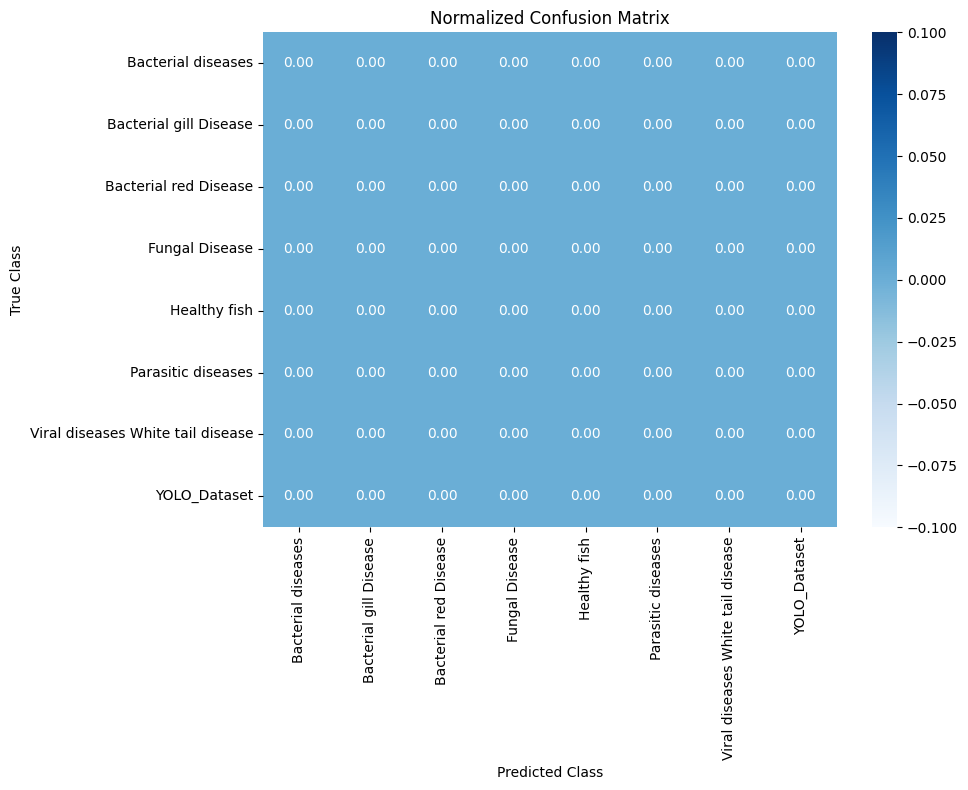

Confusion matrix heatmap saved to: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/ALL_GRAPHS/confusion_matrix_heatmap.png


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
from sklearn.metrics import ConfusionMatrixDisplay

# Define consistent paths based on previous steps
OUTPUT_ROOT_GLOBAL = globals().get('OUTPUT_ROOT', "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline")
PROJECT_NAME_GLOBAL = globals().get('PROJECT_NAME', "YOLO11_Training_Project")
RUN_NAME_ACTUAL_GLOBAL = globals().get('RUN_NAME_ACTUAL', "YOLO11_Run19")

# Path to the saved confusion matrix
DIR_ANALYSIS = os.path.join(OUTPUT_ROOT_GLOBAL, PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL, "analysis")
confusion_matrix_path = os.path.join(DIR_ANALYSIS, "confusion_matrix.npy")

# Path to the data YAML file to get class names
DATA_YAML = "/content/drive/MyDrive/split/fixed.yaml"

# Load the confusion matrix
conf_mat = np.load(confusion_matrix_path)

# Load class names from the YAML file
with open(DATA_YAML) as f:
    data_cfg = yaml.safe_load(f)
names = data_cfg["names"]

# Remove the last row/column which represents 'background'/'no object' for plotting classes
# The saved confusion matrix has an extra row for False Positives (predicted but no GT) and column for False Negatives (GT but no prediction)
# For a class-wise confusion matrix, we consider actual vs predicted classes.
# conf_mat[i,j] means GT class i, Predicted class j
# conf_mat[i, K] means GT class i, No prediction (FN)
# conf_mat[K, j] means No GT, Predicted class j (FP)

# For plotting actual vs predicted, we need only the K x K part.
num_classes = len(names)
plot_conf_mat = conf_mat[:num_classes, :num_classes]

# Normalize the confusion matrix for better visualization
# Divide each row by the sum of the row to show recall (percentage of actual class correctly predicted)
plot_conf_mat_normalized = plot_conf_mat.astype('float') / plot_conf_mat.sum(axis=1)[:, np.newaxis]
plot_conf_mat_normalized[np.isnan(plot_conf_mat_normalized)] = 0 # Handle cases where row sum is zero

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(plot_conf_mat_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=names, yticklabels=names, ax=ax)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot to GRAPH_DIR
GRAPH_DIR = os.path.join(OUTPUT_ROOT_GLOBAL, "ALL_GRAPHS")
confusion_matrix_plot_path = os.path.join(GRAPH_DIR, "confusion_matrix_heatmap.png")
plt.savefig(confusion_matrix_plot_path)
plt.show()

print(f"Confusion matrix heatmap saved to: {confusion_matrix_plot_path}")

# Task
To gain insights into the model's performance, I will first inspect the raw predictions from `predictions_test.csv`. Afterwards, I will recalculate and visualize a confusion matrix with a lower IoU threshold (0.25) to identify potential localization issues, and then visualize a few sample predictions to assess their quality.

## Inspect Raw Predictions

### Subtask:
Load and display the first few entries from the `predictions_test.csv` file to examine the model's raw predictions (bounding box coordinates, class, confidence scores). This helps understand if the model is making any detections at all, and what their confidence levels are.


**Reasoning**:
Load the 'predictions_test.csv' file into a pandas DataFrame and display its head to inspect the raw predictions.



In [ ]:
import pandas as pd
import os

# Ensure global variables are available or define fallbacks
PROJECT_NAME_GLOBAL = globals().get('PROJECT_NAME', "YOLO11_Training_Project")
RUN_NAME_ACTUAL_GLOBAL = globals().get('RUN_NAME_ACTUAL', "YOLO11_Run19")
OUTPUT_ROOT_GLOBAL = globals().get('OUTPUT_ROOT', "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline")

# Path to the predictions CSV file
PREDICTIONS_CSV_DRIVE = os.path.join(OUTPUT_ROOT_GLOBAL, PROJECT_NAME_GLOBAL, RUN_NAME_ACTUAL_GLOBAL, "predictions", "predictions_test.csv")

print(f"Loading predictions from: {PREDICTIONS_CSV_DRIVE}")

# Load the predictions_test.csv file into a Pandas DataFrame
try:
    predictions_df = pd.read_csv(PREDICTIONS_CSV_DRIVE)
    print("Successfully loaded predictions_test.csv. Displaying first 5 rows:")
    # Display the first few rows of the DataFrame
    print(predictions_df.head())
except FileNotFoundError:
    print(f"Error: {PREDICTIONS_CSV_DRIVE} not found. Please ensure the path is correct and the file exists.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

Loading predictions from: /content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/predictions/predictions_test.csv
Successfully loaded predictions_test.csv. Displaying first 5 rows:
                                               image          x1          y1  \
0  /content/drive/MyDrive/split/test/images/0001_...    0.000000   76.581360   
1  /content/drive/MyDrive/split/test/images/0001_...   28.154419    7.521118   
2  /content/drive/MyDrive/split/test/images/0001_...    1.039307    0.716667   
3  /content/drive/MyDrive/split/test/images/0002_...  126.049988  166.163361   
4  /content/drive/MyDrive/split/test/images/0009_...   32.581738  144.128525   

           x2          y2  class      conf  
0  466.897095  634.211060      1  0.711027  
1  638.729736  627.796387      0  0.462904  
2  218.547791   65.661339      2  0.257058  
3  593.152527  469.503387      1  0.911951  
4  474.142395  446.660492      4  0.782301  


✔ Final usable rows: 857


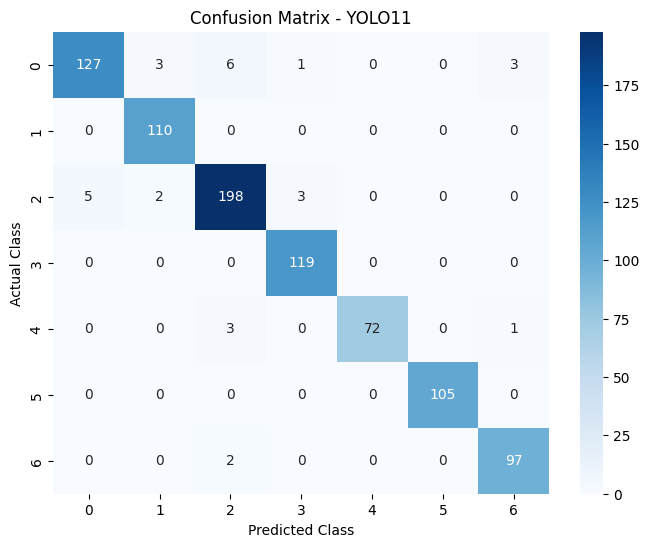

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ============================
# Paths
# ============================
csv_path = "/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/YOLO11_Training_Project/YOLO11_Run19/predictions/predictions_test.csv"
label_root = "/content/drive/MyDrive/split/test/labels"

# ============================
# Load predictions
# ============================
df = pd.read_csv(csv_path)
df["filename"] = df["image"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

actual_classes = []

for fname in df["filename"]:
    label_path = f"{label_root}/{fname}.txt"

    if not os.path.exists(label_path):
        actual_classes.append(None)
        continue

    with open(label_path, "r") as f:
        lines = f.readlines()

        # If label file is empty → skip
        if len(lines) == 0:
            actual_classes.append(None)
            continue

        # Take first object’s class only
        parts = lines[0].strip().split()

        # If corrupt line
        if len(parts) == 0:
            actual_classes.append(None)
            continue

        actual_classes.append(int(parts[0]))

df["actual"] = actual_classes

# Remove rows where actual label missing
df = df.dropna(subset=["actual"])
df["actual"] = df["actual"].astype(int)

print("✔ Final usable rows:", len(df))

# ============================
# Create Confusion Matrix
# ============================
from sklearn.metrics import confusion_matrix

y_true = df["actual"]
y_pred = df["class"]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix - YOLO11")
plt.show()


In [ ]:
import yaml

# ==== YOUR DATASET YAML PATH ====
yaml_path = "/content/drive/MyDrive/split/fixed.yaml"

# Load YAML
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Extract class names
class_names = data.get("names", [])

print("Detected Classes:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

# Auto-generate disease mapping
disease_map = {i: name for i, name in enumerate(class_names)}

print("\nGenerated disease_map:")
print(disease_map)


Detected Classes:
0: Bacterial diseases
1: Bacterial gill Disease
2: Bacterial red Disease
3: Fungal Disease
4: Healthy fish
5: Parasitic diseases
6: Viral diseases White tail disease
7: YOLO_Dataset

Generated disease_map:
{0: 'Bacterial diseases', 1: 'Bacterial gill Disease', 2: 'Bacterial red Disease', 3: 'Fungal Disease', 4: 'Healthy fish', 5: 'Parasitic diseases', 6: 'Viral diseases White tail disease', 7: 'YOLO_Dataset'}


Saving Screenshot 2025-12-06 175409.png to Screenshot 2025-12-06 175409.png
User Uploaded: Screenshot 2025-12-06 175409.png

image 1/1 /content/Screenshot 2025-12-06 175409.png: 608x640 1 Bacterial red Disease, 56.5ms
Speed: 2.3ms preprocess, 56.5ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

📌 Detection Result:
-------------------------
Detected Class: 2
Confidence: 0.648
Disease: Bacterial red Disease


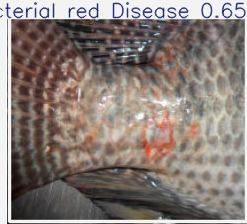

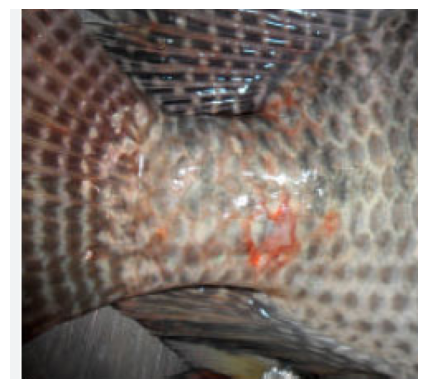

In [ ]:
from ultralytics import YOLO
from google.colab import files
import cv2
import matplotlib.pyplot as plt

# Load model
model = YOLO("/content/drive/MyDrive/Fish_Dataset_YAML_Pipeline/weights/best.pt")

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    print("User Uploaded:", img_path)

    # --- High accuracy prediction ---
    results = model.predict(img_path, imgsz=640, conf=0.25)[0]  # force 640 size

    # If no detections
    if len(results.boxes) == 0:
        print("\n❌ No detection found!")
        print("👉 Try uploading a clearer or closer fish image.")
        continue

    # Take best prediction
    boxes = results.boxes
    best_idx = boxes.conf.argmax()

    pred_class = int(boxes.cls[best_idx])
    pred_conf = float(boxes.conf[best_idx])

    # Disease mapping (auto from YAML)
    disease = disease_map.get(pred_class, "Unknown Disease")

    print("\n📌 Detection Result:")
    print("-------------------------")
    print("Detected Class:", pred_class)
    print("Confidence:", round(pred_conf, 3))
    print("Disease:", disease)

    # Show YOLO output
    results.show()

    # Show image plain
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
